## Case study: Epithelial cells in different intestinal regions by 10x Chromium
本ipython notebook是分子系统生物学提交的“单细胞RNA序列分析最佳实践：教程”的一部分。
这里，使用各种工具分析了小鼠肠上皮不同区域的数据集（来自Haber et al. 2018）。
数据集包含大约13,000个细胞，其中大约三分之一来自十二指肠、空肠和回肠。这些是小鼠肠上皮(IE)的区域。十二指肠和空肠在IE的近端，回肠在IE的远端。

最终整合的数据里我们有13,353个细胞和27,998个基因。

### Loading the libraries

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import gprofiler
from anndata import AnnData

import sys

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [2]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.17.3 scipy==1.4.1 pandas==1.1.0 scikit-learn==0.22.1 statsmodels==0.11.1 python-igraph==0.8.2 louvain==0.7.0


### 1. Reading in the data
本ipython notebook使用的数据集来自Gene Expression Omnibus (GEO)，从GSE92332_RAW.tar文件里提取的数据。

这些数据分别是：

GSM2836573_Regional_Duo_M1_barcodes.tsv
GSM2836573_Regional_Duo_M1_genes.tsv
GSM2836573_Regional_Duo_M1_matrix.mtx

GSM2836574_Regional_Duo_M2_barcodes.tsv
GSM2836574_Regional_Duo_M2_genes.tsv
GSM2836574_Regional_Duo_M2_matrix.mtx

GSM2836575_Regional_Jej_M1_barcodes.tsv
GSM2836575_Regional_Jej_M1_genes.tsv
GSM2836575_Regional_Jej_M1_matrix.mtx

GSM2836576_Regional_Jej_M2_barcodes.tsv
GSM2836576_Regional_Jej_M2_genes.tsv
GSM2836576_Regional_Jej_M2_matrix.mtx

GSM2836577_Regional_Il_M1_barcodes.tsv
GSM2836577_Regional_Il_M1_genes.tsv
GSM2836577_Regional_Il_M1_matrix.mtx

GSM2836578_Regional_Il_M2_barcodes.tsv
GSM2836578_Regional_Il_M2_genes.tsv
GSM2836578_Regional_Il_M2_matrix.mtx

Macosko_cell_cycle_genes.txt包含不同细胞周期阶段的标记基因列表

In [3]:
# Set up data loading

#Data files
sample_strings = ['Duo_M1', 'Duo_M2', 'Jej_M1', 'Jej_M2', 'Il_M1', 'Il_M2']
sample_id_strings = ['3', '4', '5', '6', '7', '8']
file_base = './GSM283657'
exp_string = '_Regional_'
data_file_end = '_matrix.mtx'
barcode_file_end = '_barcodes.tsv'
gene_file_end = '_genes.tsv'
cc_genes_file = './Macosko_cell_cycle_genes.txt'

#### (1)首先读取'Duo_M1'这个数据集，并命名为adata

In [4]:
# First data set load & annotation
#Parse Filenames
sample = sample_strings.pop(0)####注意：.pop(0)函数，每执行一次，读取的数据都不一样
sample_id = sample_id_strings.pop(0)
data_file = file_base+sample_id+exp_string+sample+data_file_end
barcode_file = file_base+sample_id+exp_string+sample+barcode_file_end
gene_file = file_base+sample_id+exp_string+sample+gene_file_end

#Load data
adata = sc.read(data_file, cache=True)
adata = adata.transpose()
adata.X = adata.X.toarray()

barcodes = pd.read_csv(barcode_file, header=None, sep='\t')
genes = pd.read_csv(gene_file, header=None, sep='\t')

#Annotate data
barcodes.rename(columns={0:'barcode'}, inplace=True)
barcodes.set_index('barcode', inplace=True)
adata.obs = barcodes
adata.obs['sample'] = [sample]*adata.n_obs
adata.obs['region'] = [sample.split("_")[0]]*adata.n_obs
adata.obs['donor'] = [sample.split("_")[1]]*adata.n_obs

genes.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
genes.set_index('gene_symbol', inplace=True)
adata.var = genes

... writing an h5ad cache file to speedup reading next time


In [7]:
##查看读取的数据
##经查看读入的数据adata是Duo_M1数据集
adata.obs

sample region donor
barcode                              
AAACATACAGCGGA-1  Duo_M1    Duo    M1
AAACATACCTTACT-1  Duo_M1    Duo    M1
AAACATACTTTGCT-1  Duo_M1    Duo    M1
AAACCGTGCAGTCA-1  Duo_M1    Duo    M1
AAACGCTGCAGTCA-1  Duo_M1    Duo    M1
...                  ...    ...   ...
TTTATCCTATGACC-1  Duo_M1    Duo    M1
TTTATCCTTCTCGC-1  Duo_M1    Duo    M1
TTTCACGAAACGTC-1  Duo_M1    Duo    M1
TTTCTACTACTGGT-1  Duo_M1    Duo    M1
TTTGACTGCGGAGA-1  Duo_M1    Duo    M1

[2348 rows x 3 columns]

In [6]:
adata.to_df()

gene_symbol       mm10_Xkr4  mm10_Gm1992  mm10_Gm37381  mm10_Rp1  mm10_Rp1  \
barcode                                                                      
AAACATACAGCGGA-1        0.0          0.0           0.0       0.0       0.0   
AAACATACCTTACT-1        0.0          0.0           0.0       0.0       0.0   
AAACATACTTTGCT-1        0.0          0.0           0.0       0.0       0.0   
AAACCGTGCAGTCA-1        0.0          0.0           0.0       0.0       0.0   
AAACGCTGCAGTCA-1        0.0          0.0           0.0       0.0       0.0   
...                     ...          ...           ...       ...       ...   
TTTATCCTATGACC-1        0.0          0.0           0.0       0.0       0.0   
TTTATCCTTCTCGC-1        0.0          0.0           0.0       0.0       0.0   
TTTCACGAAACGTC-1        0.0          0.0           0.0       0.0       0.0   
TTTCTACTACTGGT-1        0.0          0.0           0.0       0.0       0.0   
TTTGACTGCGGAGA-1        0.0          0.0           0.0       0.0       0.0   

gene_symbol       mm10_Sox17  mm10_Gm37323  mm10_Mrpl15  mm10_Lypla1  \
barcode                                                                
AAACATACAGCGGA-1         0.0           0.0          0.0          0.0   
AAACATACCTTACT-1         0.0           0.0          1.0          2.0   
AAACATACTTTGCT-1         0.0           0.0          2.0          0.0   
AAACCGTGCAGTCA-1         0.0           0.0          1.0          0.0   
AAACGCTGCAGTCA-1         0.0           0.0          3.0          0.0   
...                      ...           ...          ...          ...   
TTTATCCTATGACC-1         0.0           0.0          2.0          1.0   
TTTATCCTTCTCGC-1         0.0           0.0          1.0          0.0   
TTTCACGAAACGTC-1         0.0           0.0          0.0          0.0   
TTTCTACTACTGGT-1         0.0           0.0          0.0          0.0   
TTTGACTGCGGAGA-1         0.0           0.0          1.0          0.0   

gene_symbol       mm10_Gm37988  ...  mm10_AC125149.1  mm10_AC125149.2  \
barcode                         ...                                     
AAACATACAGCGGA-1           0.0  ...              0.0              0.0   
AAACATACCTTACT-1           0.0  ...              0.0              0.0   
AAACATACTTTGCT-1           0.0  ...              0.0              0.0   
AAACCGTGCAGTCA-1           0.0  ...              0.0              0.0   
AAACGCTGCAGTCA-1           0.0  ...              0.0              0.0   
...                        ...  ...              ...              ...   
TTTATCCTATGACC-1           0.0  ...              0.0              0.0   
TTTATCCTTCTCGC-1           0.0  ...              0.0              0.0   
TTTCACGAAACGTC-1           0.0  ...              0.0              0.0   
TTTCTACTACTGGT-1           0.0  ...              0.0              0.0   
TTTGACTGCGGAGA-1           0.0  ...              0.0              0.0   

gene_symbol       mm10_AC125149.4  mm10_AC234645.1  mm10_AC168977.2  \
barcode                                                               
AAACATACAGCGGA-1              0.0              0.0              0.0   
AAACATACCTTACT-1              0.0              0.0              0.0   
AAACATACTTTGCT-1              0.0              0.0              0.0   
AAACCGTGCAGTCA-1              0.0              0.0              0.0   
AAACGCTGCAGTCA-1              0.0              0.0              0.0   
...                           ...              ...              ...   
TTTATCCTATGACC-1              0.0              0.0              0.0   
TTTATCCTTCTCGC-1              0.0              0.0              0.0   
TTTCACGAAACGTC-1              0.0              0.0              0.0   
TTTCTACTACTGGT-1              0.0              0.0              0.0   
TTTGACTGCGGAGA-1              0.0              0.0              0.0   

gene_symbol       mm10_AC168977.1  mm10_PISD  mm10_DHRSX  mm10_Vmn2r122  \
barcode                                                                   
AAACATACAGCGGA-1        

#### (2)利用for循环将adata和剩下的数据集进行合并

In [8]:
# Loop to load rest of data sets
for i in range(len(sample_strings)):
    #Parse Filenames
    sample = sample_strings[i]
    sample_id = sample_id_strings[i]
    data_file = file_base+sample_id+exp_string+sample+data_file_end
    barcode_file = file_base+sample_id+exp_string+sample+barcode_file_end
    gene_file = file_base+sample_id+exp_string+sample+gene_file_end
    
    #Load data
    adata_tmp = sc.read(data_file, cache=True)
    adata_tmp = adata_tmp.transpose()
    adata_tmp.X = adata_tmp.X.toarray()
    
    barcodes_tmp = pd.read_csv(barcode_file, header=None, sep='\t')
    genes_tmp = pd.read_csv(gene_file, header=None, sep='\t')
    
    #Annotate data
    barcodes_tmp.rename(columns={0:'barcode'}, inplace=True)
    barcodes_tmp.set_index('barcode', inplace=True)
    adata_tmp.obs = barcodes_tmp
    adata_tmp.obs['sample'] = [sample]*adata_tmp.n_obs
    adata_tmp.obs['region'] = [sample.split("_")[0]]*adata_tmp.n_obs
    adata_tmp.obs['donor'] = [sample.split("_")[1]]*adata_tmp.n_obs
    
    genes_tmp.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
    genes_tmp.set_index('gene_symbol', inplace=True)
    adata_tmp.var = genes_tmp
    adata_tmp.var_names_make_unique()
 

    # Concatenate to main adata object
    adata.var_names_make_unique()
    adata = adata.concatenate(adata_tmp, batch_key='sample_id')
    #adata.var['gene_id'] = adata.var['gene_id-1']
    #adata.var.drop(columns = ['gene_id-1', 'gene_id-0'], inplace=True)
    adata.obs.drop(columns=['sample_id'], inplace=True)
    adata.obs_names = [c.split("-")[0] for c in adata.obs_names]
    adata.obs_names_make_unique(join='_')

... writing an h5ad cache file to speedup reading next time
... writing an h5ad cache file to speedup reading next time
... writing an h5ad cache file to speedup reading next time
... writing an h5ad cache file to speedup reading next time
... writing an h5ad cache file to speedup reading next time


In [9]:
####查看合并的数据
####经查看已将Duo_M1、Duo_M2、Jej_M1、Jej_M2、Il_M1和Il_M2数据集进行了合并
adata.obs

sample region donor
AAACATACAGCGGA  Duo_M1    Duo    M1
AAACATACCTTACT  Duo_M1    Duo    M1
AAACATACTTTGCT  Duo_M1    Duo    M1
AAACCGTGCAGTCA  Duo_M1    Duo    M1
AAACGCTGCAGTCA  Duo_M1    Duo    M1
...                ...    ...   ...
TTTCGAACAGAACA   Il_M2     Il    M2
TTTCGAACCAGTCA   Il_M2     Il    M2
TTTCTACTGCTCCT   Il_M2     Il    M2
TTTGACTGCGCCTT   Il_M2     Il    M2
TTTGCATGGAGGAC   Il_M2     Il    M2

[13353 rows x 3 columns]

In [10]:
##查看合并后的数据集具体内容
adata.to_df()

gene_symbol     mm10_Xkr4  mm10_Gm1992  mm10_Gm37381  mm10_Rp1  mm10_Rp1-1  \
AAACATACAGCGGA        0.0          0.0           0.0       0.0         0.0   
AAACATACCTTACT        0.0          0.0           0.0       0.0         0.0   
AAACATACTTTGCT        0.0          0.0           0.0       0.0         0.0   
AAACCGTGCAGTCA        0.0          0.0           0.0       0.0         0.0   
AAACGCTGCAGTCA        0.0          0.0           0.0       0.0         0.0   
...                   ...          ...           ...       ...         ...   
TTTCGAACAGAACA        0.0          0.0           0.0       0.0         0.0   
TTTCGAACCAGTCA        0.0          0.0           0.0       0.0         0.0   
TTTCTACTGCTCCT        0.0          0.0           0.0       0.0         0.0   
TTTGACTGCGCCTT        0.0          0.0           0.0       0.0         0.0   
TTTGCATGGAGGAC        0.0          0.0           0.0       0.0         0.0   

gene_symbol     mm10_Sox17  mm10_Gm37323  mm10_Mrpl15  mm10_Lypla1  \
AAACATACAGCGGA         0.0           0.0          0.0          0.0   
AAACATACCTTACT         0.0           0.0          1.0          2.0   
AAACATACTTTGCT         0.0           0.0          2.0          0.0   
AAACCGTGCAGTCA         0.0           0.0          1.0          0.0   
AAACGCTGCAGTCA         0.0           0.0          3.0          0.0   
...                    ...           ...          ...          ...   
TTTCGAACAGAACA         0.0           0.0          2.0          1.0   
TTTCGAACCAGTCA         0.0           0.0          0.0          0.0   
TTTCTACTGCTCCT         0.0           0.0          5.0          2.0   
TTTGACTGCGCCTT         0.0           0.0          0.0          0.0   
TTTGCATGGAGGAC         0.0           0.0          5.0          1.0   

gene_symbol     mm10_Gm37988  ...  mm10_AC125149.1  mm10_AC125149.2  \
AAACATACAGCGGA           0.0  ...              0.0              0.0   
AAACATACCTTACT           0.0  ...              0.0              0.0   
AAACATACTTTGCT           0.0  ...              0.0              0.0   
AAACCGTGCAGTCA           0.0  ...              0.0              0.0   
AAACGCTGCAGTCA           0.0  ...              0.0              0.0   
...                      ...  ...              ...              ...   
TTTCGAACAGAACA           0.0  ...              0.0              0.0   
TTTCGAACCAGTCA           0.0  ...              0.0              0.0   
TTTCTACTGCTCCT           0.0  ...              0.0              0.0   
TTTGACTGCGCCTT           0.0  ...              0.0              0.0   
TTTGCATGGAGGAC           0.0  ...              0.0              0.0   

gene_symbol     mm10_AC125149.4  mm10_AC234645.1  mm10_AC168977.2  \
AAACATACAGCGGA              0.0              0.0              0.0   
AAACATACCTTACT              0.0              0.0              0.0   
AAACATACTTTGCT              0.0              0.0              0.0   
AAACCGTGCAGTCA              0.0              0.0              0.0   
AAACGCTGCAGTCA              0.0              0.0              0.0   
...                         ...              ...              ...   
TTTCGAACAGAACA              0.0              0.0              0.0   
TTTCGAACCAGTCA              0.0              0.0              0.0   
TTTCTACTGCTCCT              0.0              0.0              0.0   
TTTGACTGCGCCTT              0.0              0.0              0.0   
TTTGCATGGAGGAC              0.0              0.0              0.0   

gene_symbol     mm10_AC168977.1  mm10_PISD  mm10_DHRSX  mm10_Vmn2r122  \
AAACATACAGCGGA              0.0        0.0         1.0            0.0   
AAACATACCTTACT              0.0        2.0         0.0            0.0   
AAACATACTTTGCT              0.0        1.0         0.0            0.0   
AAACCGTGCAGTCA              0.0        0.0         0.0            0.0   
AAACGCTGCAGTCA              0.0        0.0         1.0            0.0   
...                         ...        ...         ...            ...   
TTTCGAACAGAACA              0

In [11]:
#Assign variable names and gene id columns
adata.var_names = [g.split("_")[1] for g in adata.var_names]
adata.var['gene_id'] = [g.split("_")[1] for g in adata.var['gene_id']]

In [12]:
# Annotate the data sets
print(adata.obs['region'].value_counts())
print('')
print(adata.obs['donor'].value_counts())
print('')
print(adata.obs['sample'].value_counts())

Duo    4554
Jej    4496
Il     4303
Name: region, dtype: int64

M2    6711
M1    6642
Name: donor, dtype: int64

Jej_M2    2668
Il_M1     2466
Duo_M1    2348
Duo_M2    2206
Il_M2     1837
Jej_M1    1828
Name: sample, dtype: int64


In [13]:
# Checking the total size of the data set
adata.shape

(13353, 27998)

最终合并的数据集中有13353个细胞，27998个基因

## 单细胞RNA测序的一般步骤

### 2.Pre-processing and visualization

### 2.1 Quality control(质量控制)

#### 质控(Quality control, QC)的目的：对低质量细胞进行质控检验，确保所有barcode 都对应于有效细胞(有活力的细胞)。
#### 质控的3个指标：a.测到的转录本分子总数 b.测到的基因总数 c.来源于线粒体基因的转录本所占比例

#### (1)线粒体基因的转录本所占比例

##### 画小提琴图判断线粒体基因所占的比例

In [14]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

mt_gene_mask = [gene.startswith('mt-') for gene in adata.var_names]
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'sample' as categorical
... storing 'region' as categorical
... storing 'donor' as categorical


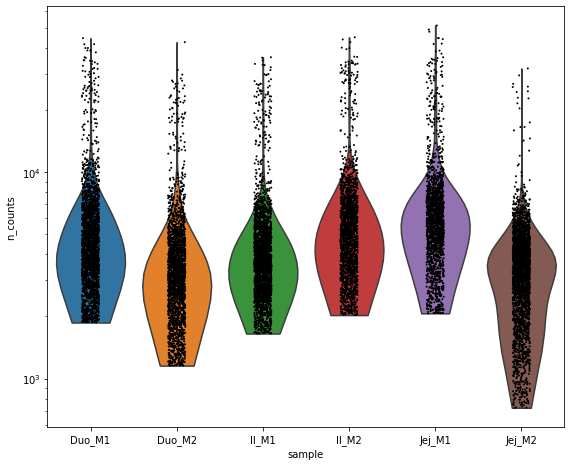

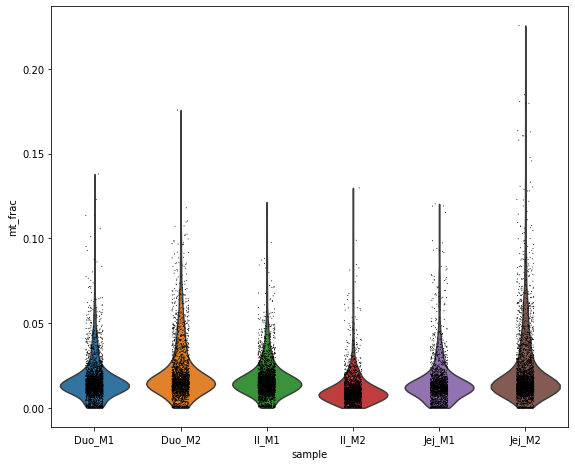

In [15]:
# Quality control - plot QC metrics
#Sample quality plots
t1 = sc.pl.violin(adata, 'n_counts', groupby='sample', size=2, log=True, cut=0)
t2 = sc.pl.violin(adata, 'mt_frac', groupby='sample')

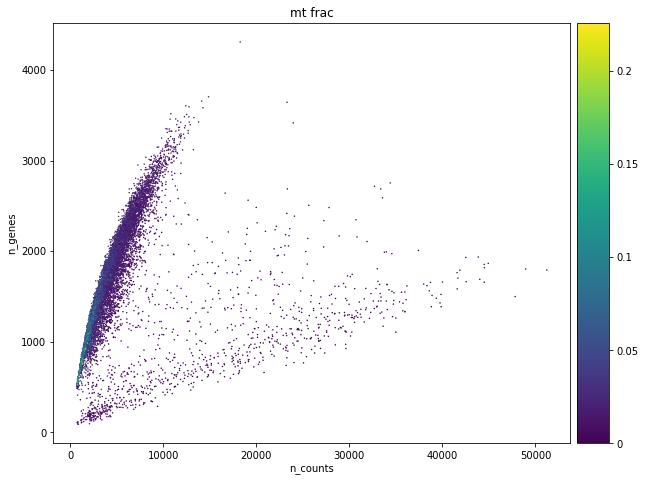

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


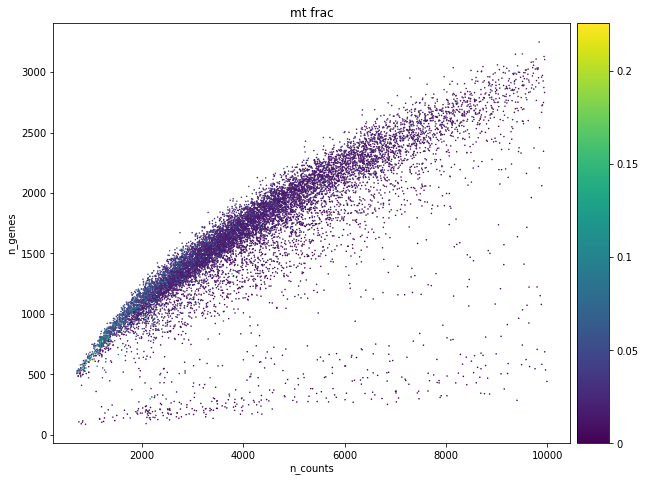

In [16]:
#Data quality summary plots
#异常值的判断
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='mt_frac')
p2 = sc.pl.scatter(adata[adata.obs['n_counts']<10000], 'n_counts', 'n_genes', color='mt_frac')

#### (2)测到的细胞和基因总数

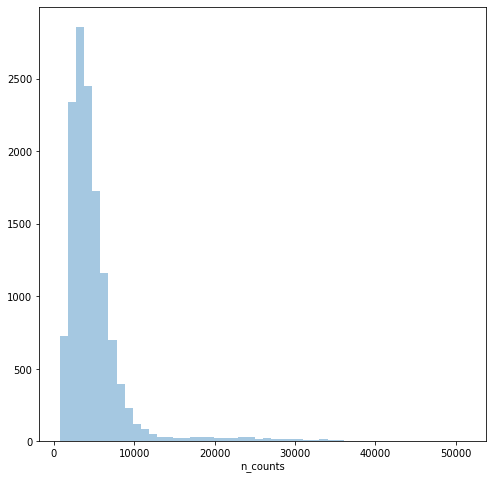

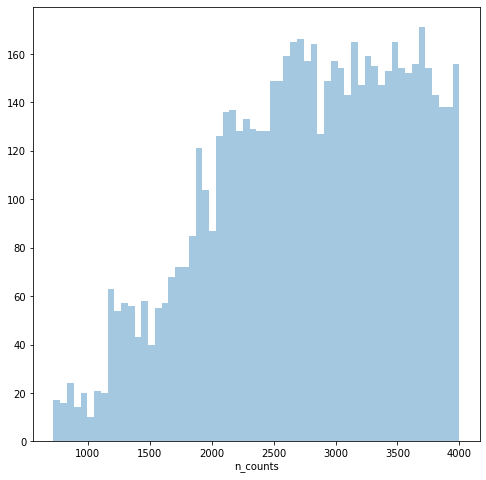

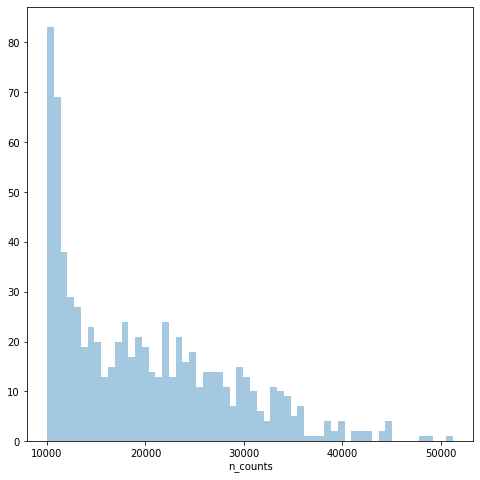

In [17]:
#Thresholding decision: counts
#对于细胞，判断出的阈值
p3 = sb.distplot(adata.obs['n_counts'], kde=False)
plt.show()

p4 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']<4000], kde=False, bins=60)
plt.show()

p5 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']>10000], kde=False, bins=60)
plt.show()

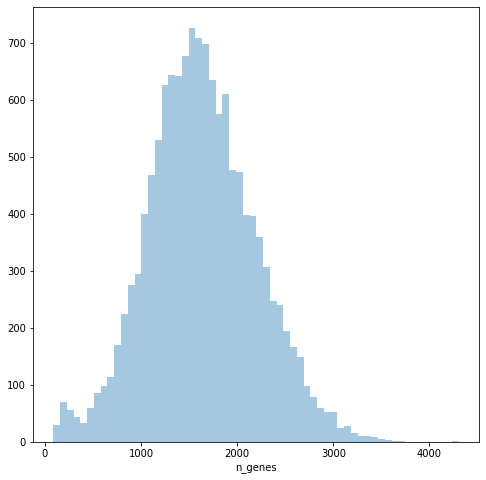

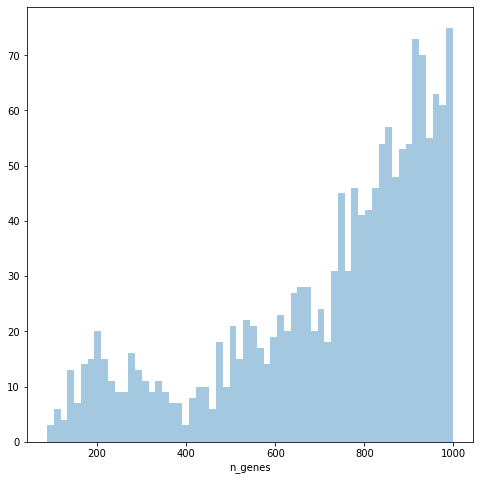

In [18]:
#Thresholding decision: genes
#对于基因，判断出的阈值
p6 = sb.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

p7 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<1000], kde=False, bins=60)
plt.show()

In [19]:
# Filter cells according to identified QC thresholds:
#根据阈值，过滤掉部分细胞和基因
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 1500)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 40000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 700)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 13353
filtered out 479 cells that have less than 1500 counts


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Number of cells after min count filter: 12874
filtered out 16 cells that have more than 40000 counts
Number of cells after max count filter: 12858
Number of cells after MT filter: 12858


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


filtered out 401 cells that have less than 700 genes expressed


Trying to set attribute `.obs` of view, copying.


Number of cells after gene filter: 12457


In [20]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 27998
filtered out 15180 genes that are detected in less than 20 cells
Number of genes after cell filter: 12818


In [21]:
#预处理，删除部分数据后的数据集
adata.shape

(12457, 12818)

经过设置的阈值，进行预处理后，最终的数据集为12457个细胞，12818个基因

### 2.2 Normalization(标准化)

#### 标准化(Normalization)的原因：使得细胞之间可比

In [22]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=15
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:11)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:01)


In [23]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [24]:
%%R -i data_mat -i input_groups -o size_factors
library(scran)
size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

In [26]:
#Delete adata_pp
del adata_pp

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


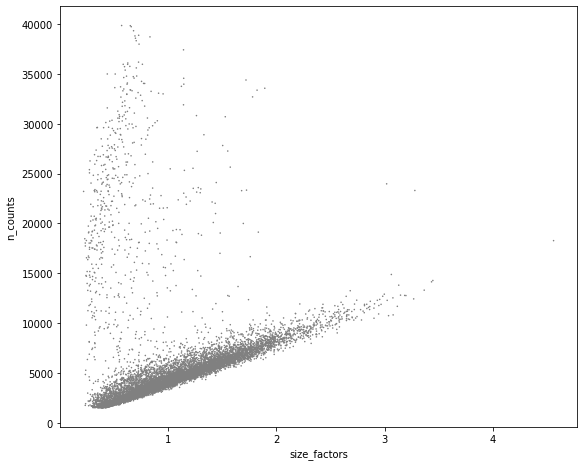

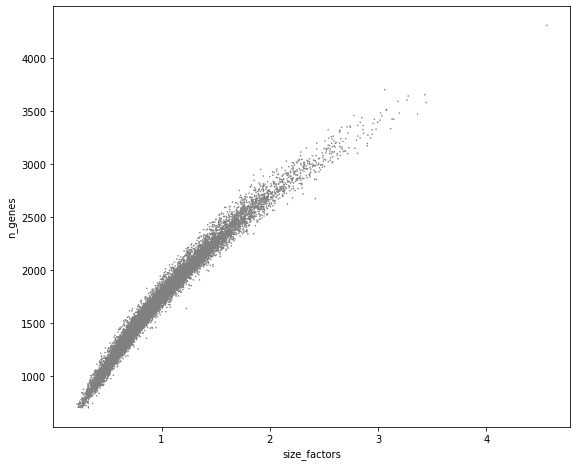

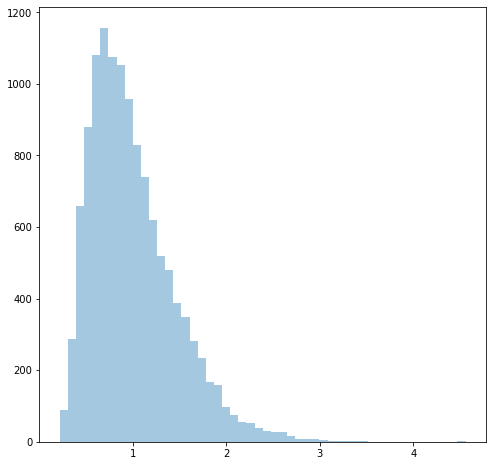

In [27]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors

sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [28]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [29]:
#Normalize adata
#对标准化的数据，取对数
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

In [30]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.raw = adata

### 2.3 Batch Correction

#### 批次效应：不同时间、不同操作者、不同试剂、不同仪器导致的实验误差

#### 批次校正(Batch Correction)的目的：减少 batch 之间的差异，尽量让多个batch 的数据重新组合在一起，这样下游分析就可以只考虑生物学差异因素。

In [31]:
# ComBat batch correction
#批次校正常用的方法：ComBat
sc.pp.combat(adata, key='sample')

Standardizing Data across genes.

Found 6 batches

Found 0 numerical variables:
	

Fitting L/S model and finding priors

Finding parametric adjustments



/usr/local/lib/python3.6/dist-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: divide by zero encountered in true_divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


Adjusting data



### 2.4 Highly Variable Genes(高变异基因)

#### 进行高变异基因的识别，其实就是在进行----特征选择

In [32]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=4000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 4000


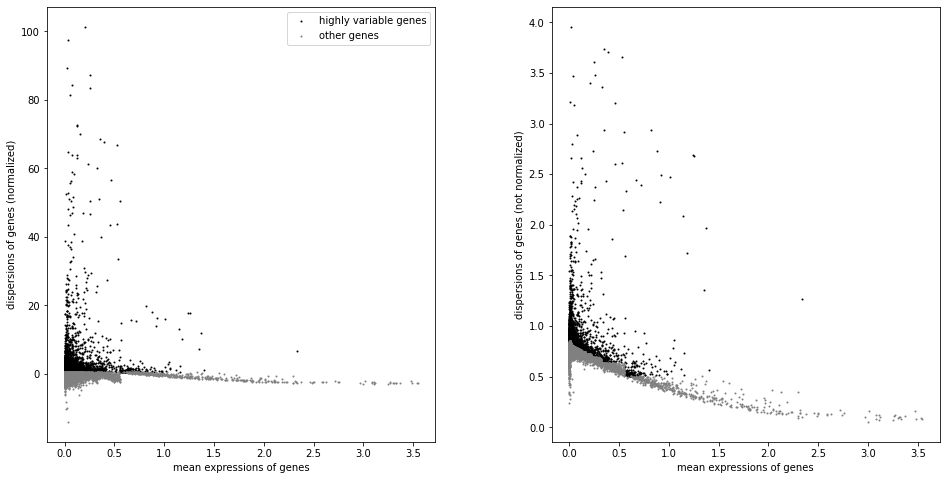

In [33]:
sc.pl.highly_variable_genes(adata)

黑色的点是高变异基因，其他基因是灰色点，我们要选择的是高变异基因

In [34]:
adata.shape

(12457, 12818)

In [37]:
##查看高变异基因
adata.var['highly_variable']

Mrpl15             True
Lypla1            False
Tcea1             False
Atp6v1h           False
Rb1cc1             True
                  ...  
Spry3             False
Tmlhe             False
PISD              False
DHRSX              True
CAAA01147332.1    False
Name: highly_variable, Length: 12818, dtype: bool

### 2.5 Visualization

#### 可视化(Visualization)scRNA-seq 数据是将细胞和基因的高维矩阵投影到几个坐标中以便每个细胞在二维图形中有意义地表示的过程。

#### 注意：最好查看几种可视化，并确定哪种可视化最能代表正在调查的数据的方面。

#### 本案例采用 PCA、t-SNE、UMAP、Diffusion Maps、Graph 这 5 种可视化方法

In [39]:
# Calculate the visualizations
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)

sc.tl.tsne(adata, n_jobs=12) #Note n_jobs works for MulticoreTSNE, but not regular implementation)
sc.tl.umap(adata)
sc.tl.diffmap(adata)
sc.tl.draw_graph(adata)

computing PCA
    on highly variable genes
    with n_comps=50


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


    finished (0:00:05)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)
computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:34)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:13)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9971263  0.9947185  0.9935045  0.9924115  0.99080414
     0.9796224  0.97773165 0.97429246 0.9694115  0.96878976 0.962524
     0.96200824 0.9566552  0.9538793 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
drawing single-cell graph

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


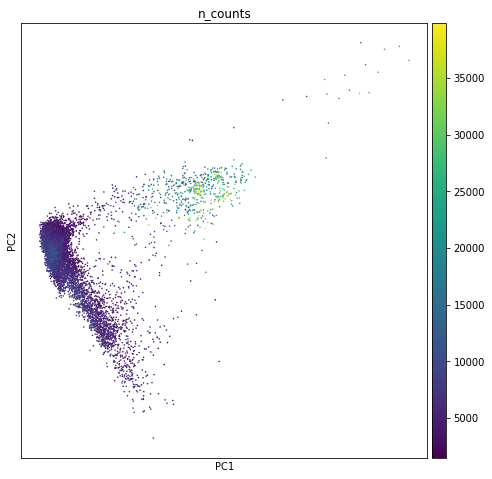

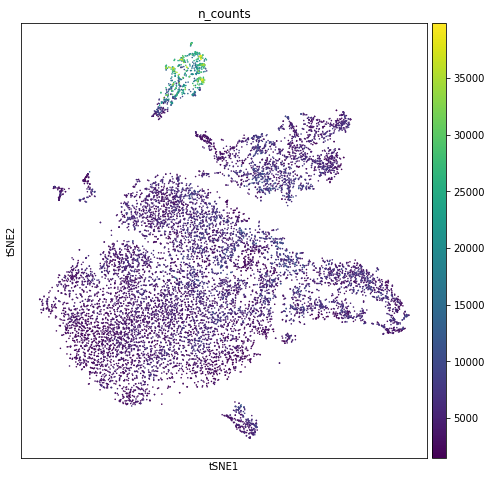

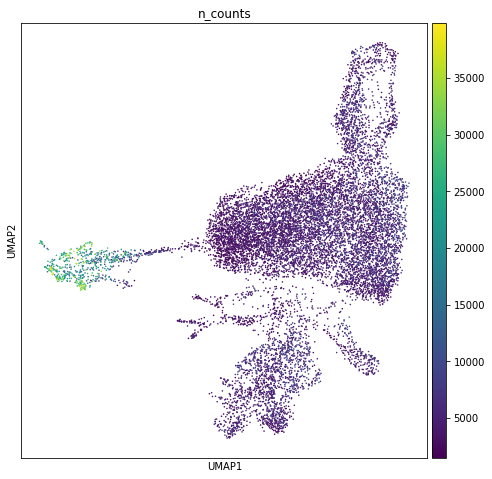

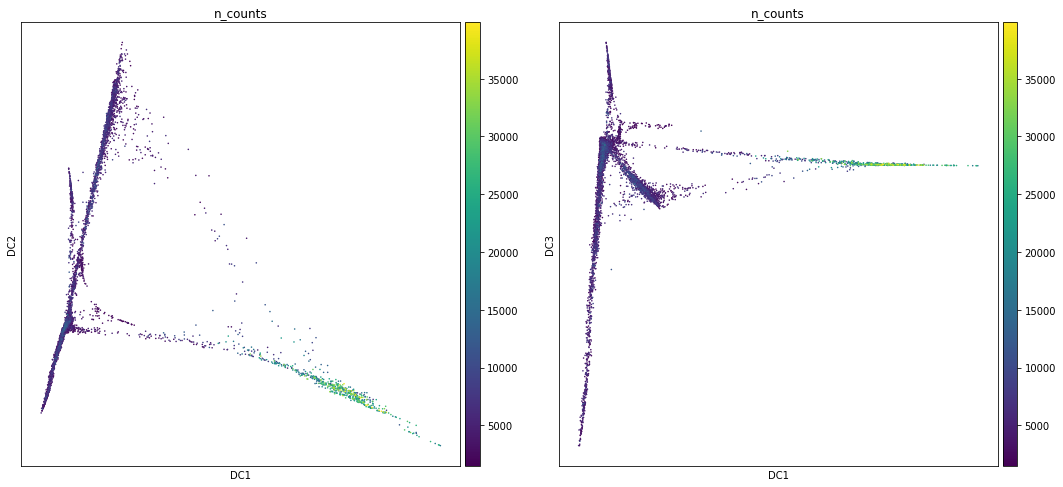

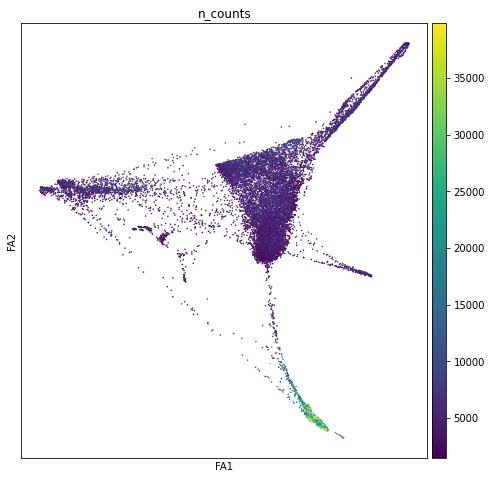

In [40]:
sc.pl.pca_scatter(adata, color='n_counts')
sc.pl.tsne(adata, color='n_counts')
sc.pl.umap(adata, color='n_counts')
sc.pl.diffmap(adata, color='n_counts', components=['1,2','1,3'])
sc.pl.draw_graph(adata, color='n_counts')

### 2.6 Cell cycle scoring

#### 细胞周期分为细胞间期和细胞分裂期。细胞间期又分为三期，即 DNA 合成前期(G1 期)、DNA 合成期(S 期)和 DNA 合成后期(G2 期)，M 期为细胞分裂期。

In [41]:
#Score cell cycle and visualize the effect:
cc_genes = pd.read_table(cc_genes_file, delimiter='\t')
s_genes = cc_genes['S'].dropna()
g2m_genes = cc_genes['G2.M'].dropna()

s_genes_mm = [gene.lower().capitalize() for gene in s_genes]
g2m_genes_mm = [gene.lower().capitalize() for gene in g2m_genes]

s_genes_mm_ens = adata.var_names[np.in1d(adata.var_names, s_genes_mm)]
g2m_genes_mm_ens = adata.var_names[np.in1d(adata.var_names, g2m_genes_mm)]

sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes_mm_ens, g2m_genes=g2m_genes_mm_ens)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    2204 total control genes are used. (0:00:01)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    2202 total control genes are used. (0:00:01)
-->     'phase', cell cycle phase (adata.obs)


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'phase' as categorical


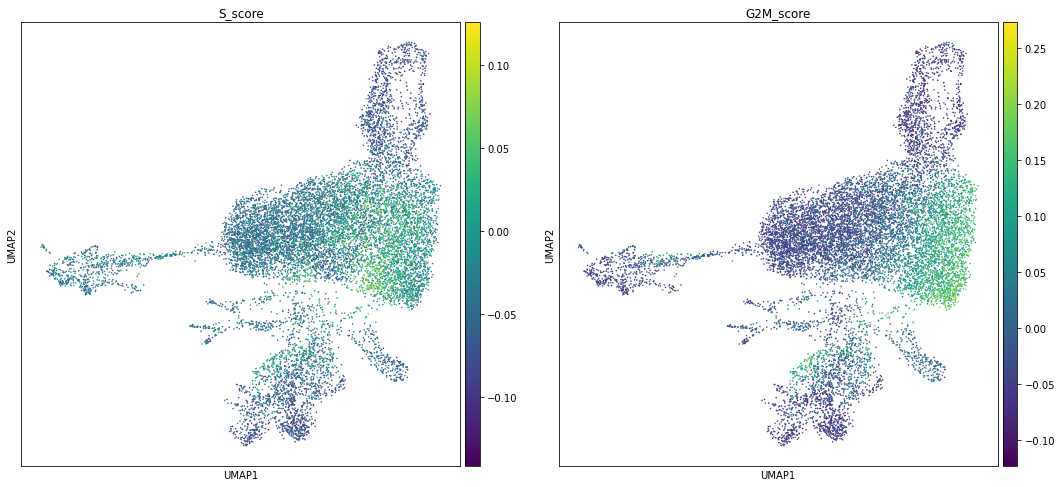

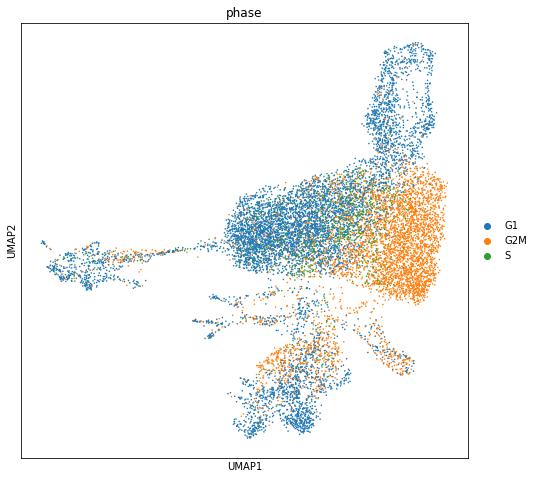

In [42]:
sc.pl.umap(adata, color=['S_score', 'G2M_score'], use_raw=False)
sc.pl.umap(adata, color='phase', use_raw=False)

### 3 Downstream analysis(下游分析)

#### 下游分析可分为细胞水平和基因水平的方法。

### (1)细胞水平

### 3.1 Clustering

#### 本案例采用的聚类方法：多分辨率模块优化算法 (multi‐resolution modularity optimization）。即在单细胞 KNN 图中应用 Louvain 算法

#### 本案例设置 resolution 分别为 1.0 和 0.5 可视化进行比较分析，更高的resolution 意味着找到更多更小的集群。

In [44]:
# Perform clustering - using highly variable genes
sc.tl.louvain(adata, key_added='louvain_r1')
sc.tl.louvain(adata, resolution=0.5, key_added='louvain_r0.5')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical) (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 9 clusters and added
    'louvain_r0.5', the cluster labels (adata.obs, categorical) (0:00:02)


In [45]:
adata.obs['louvain_r0.5'].value_counts()

0    2577
1    2562
2    2364
3    1803
4    1218
5     747
6     641
7     288
8     257
Name: louvain_r0.5, dtype: int64

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


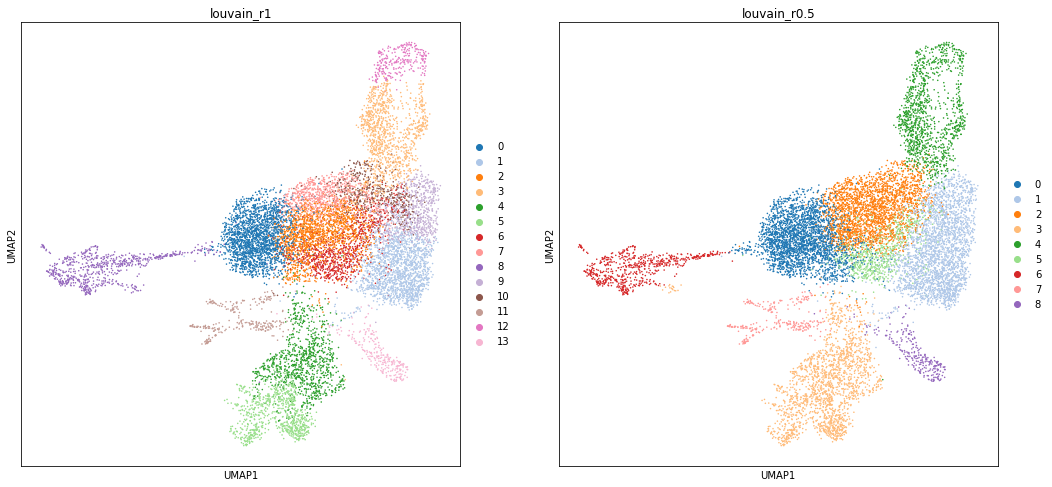

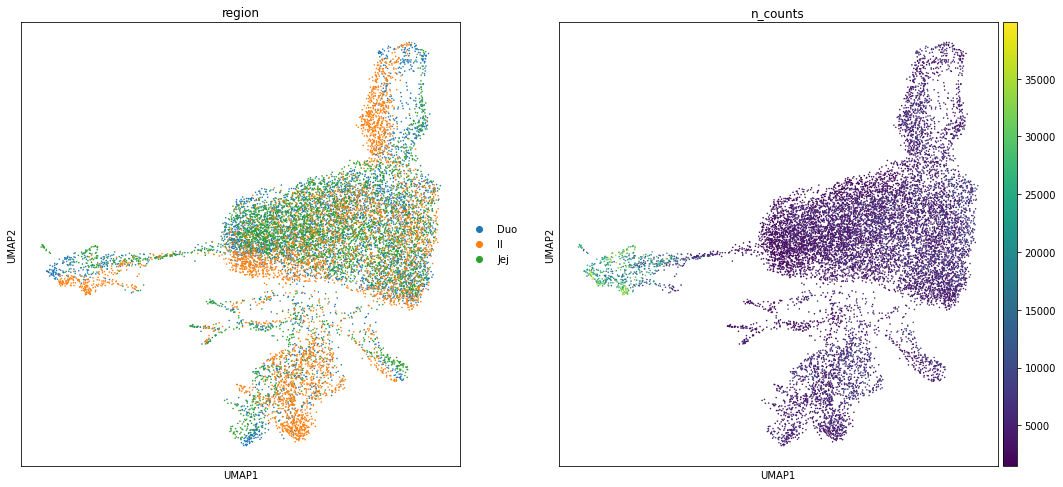

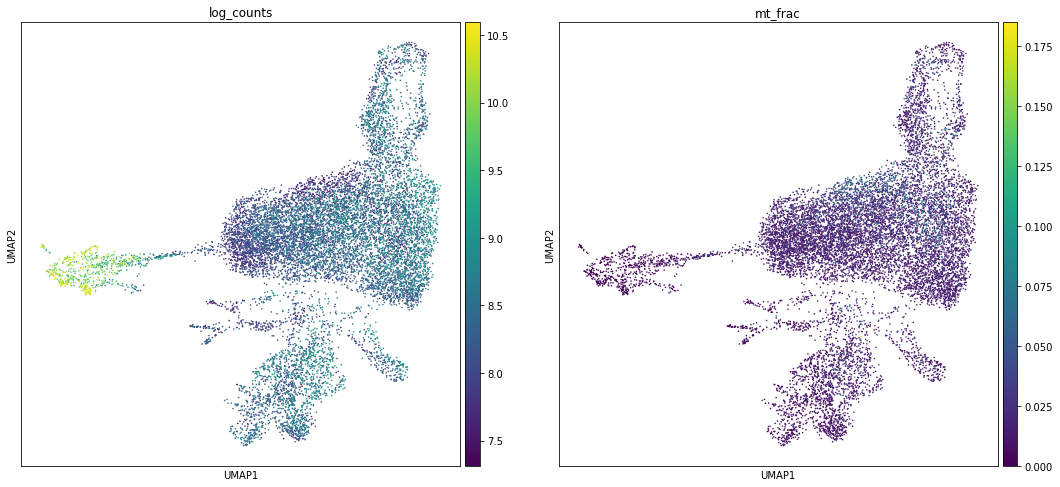

In [46]:
#Visualize the clustering and how this is reflected by different technical covariates
#################################
##这里报错了，我把 palette=sc.pl.palettes.default_64，删掉了，改为sc.pl.palettes.vega_20
################################
sc.pl.umap(adata, color=['louvain_r1', 'louvain_r0.5'],palette=sc.pl.palettes.vega_20)
sc.pl.umap(adata, color=['region', 'n_counts'])
sc.pl.umap(adata, color=['log_counts', 'mt_frac'])

### 3.2 Marker genes & cluster annotation(标记基因与聚类注释)

#### 进行细胞簇的注释

In [47]:
#Calculate marker genes
sc.tl.rank_genes_groups(adata, groupby='louvain_r0.5', key_added='rank_genes_r0.5')

ranking genes
    finished: added to `.uns['rank_genes_r0.5']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)


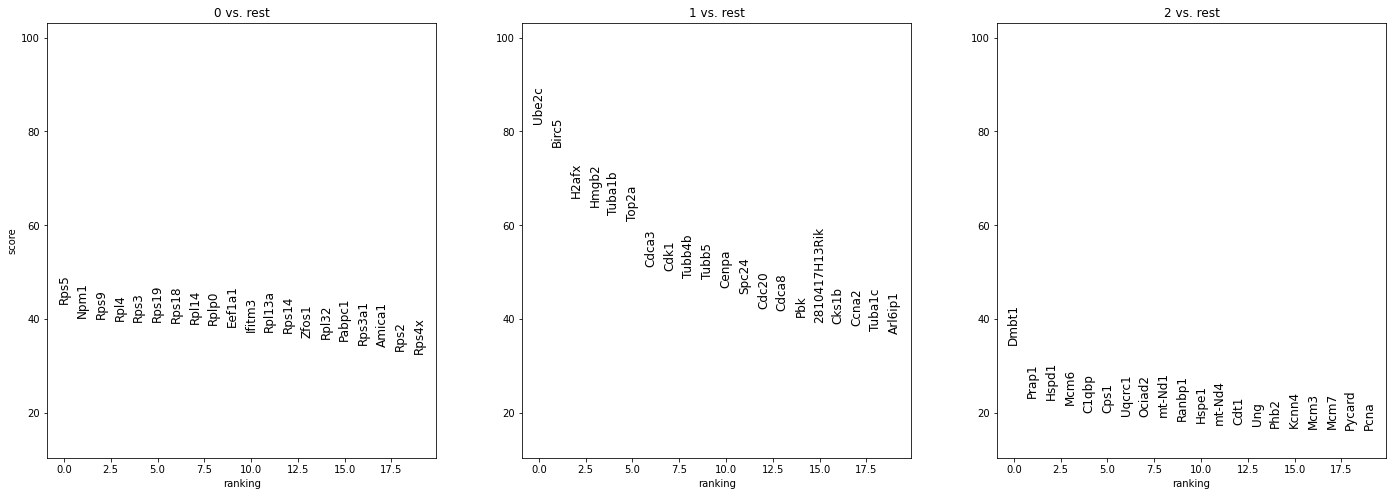

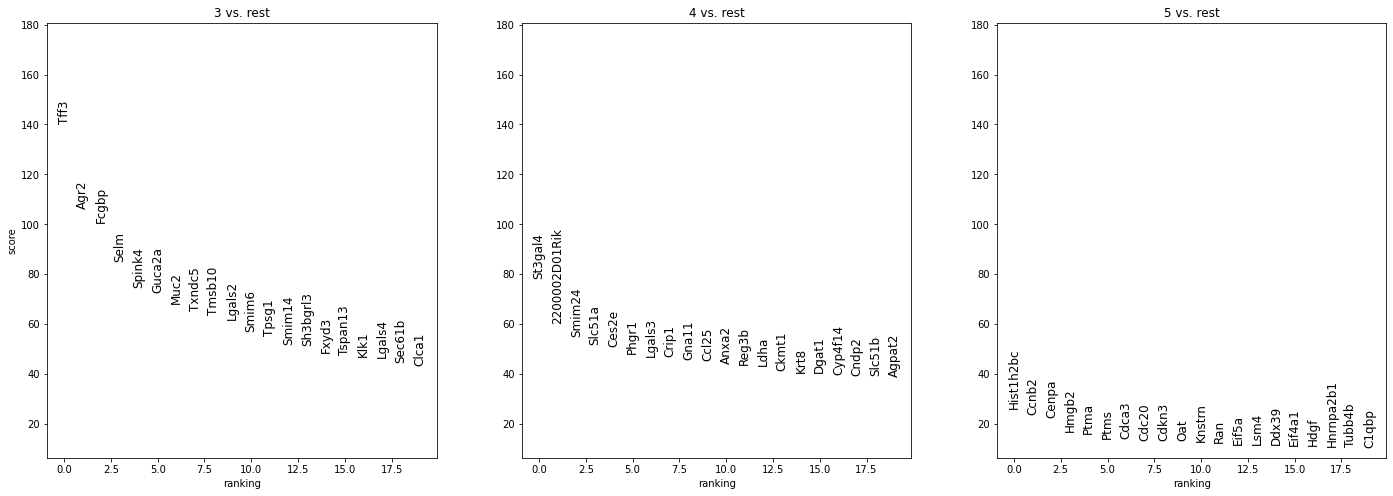

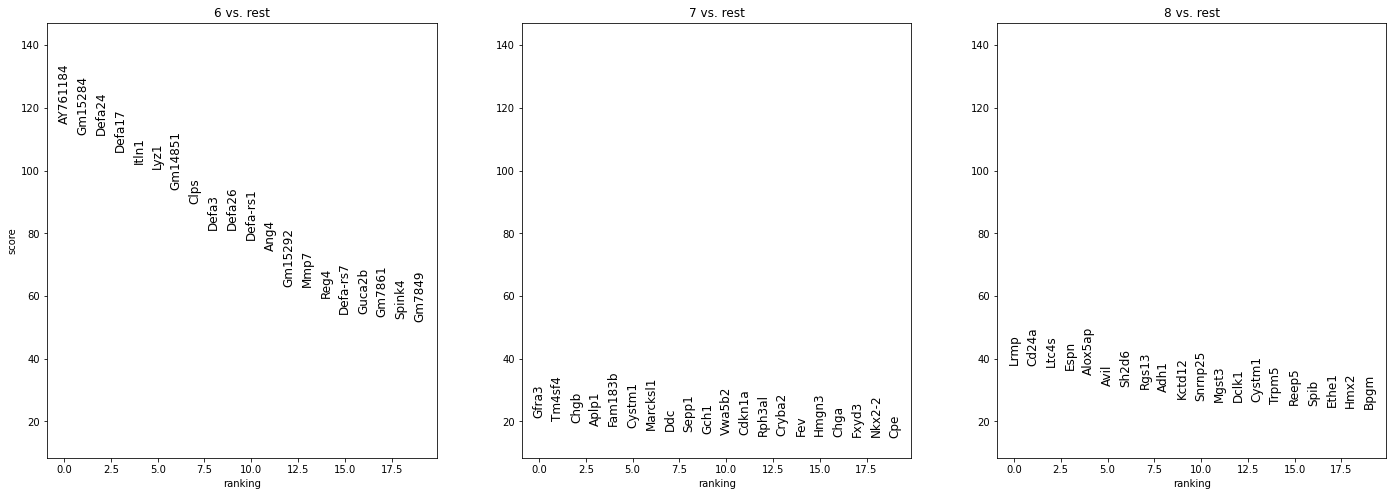

In [48]:
#Plot marker genes
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.5', groups=['0','1','2'], fontsize=12)
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.5', groups=['3','4','5'], fontsize=12)
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.5', groups=['6', '7', '8'], fontsize=12)

In [49]:
#Known marker genes:
marker_genes = dict()
marker_genes['Stem'] = ['Lgr5', 'Ascl2', 'Slc12a2', 'Axin2', 'Olfm4', 'Gkn3']
marker_genes['Enterocyte (Proximal)'] = ['Gsta1','Rbp2','Adh6a','Apoa4','Reg3a','Creb3l3','Cyp3a13','Cyp2d26','Ms4a10','Ace','Aldh1a1','Rdh7','H2-Q2', 'Hsd17b6','Gstm3','Gda','Apoc3','Gpd1','Fabp1','Slc5a1','Mme','Cox7a1','Gsta4','Lct','Khk','Mttp','Xdh','Sult1b1', 'Treh','Lpgat1','Dhrs1','Cyp2c66','Ephx2','Cyp2c65','Cyp3a25','Slc2a2','Ugdh','Gstm6','Retsat','Ppap2a','Acsl5', 'Cyb5r3','Cyb5b','Ckmt1','Aldob','Ckb','Scp2','Prap1']
marker_genes['Enterocyte (Distal)'] = ['Tmigd1','Fabp6','Slc51b','Slc51a','Mep1a','Fam151a','Naaladl1','Slc34a2','Plb1','Nudt4','Dpep1','Pmp22','Xpnpep2','Muc3','Neu1','Clec2h','Phgr1','2200002D01Rik','Prss30','Cubn','Plec','Fgf15','Crip1','Krt20','Dhcr24','Myo15b','Amn','Enpep','Anpep','Slc7a9','Ocm','Anxa2','Aoc1','Ceacam20','Arf6','Abcb1a','Xpnpep1','Vnn1','Cndp2','Nostrin','Slc13a1','Aspa','Maf','Myh14']
marker_genes['Goblet'] = ['Agr2', 'Fcgbp', 'Tff3', 'Clca1', 'Zg16', 'Tpsg1', 'Muc2', 'Galnt12', 'Atoh1', 'Rep15', 'S100a6', 'Pdia5', 'Klk1', 'Pla2g10', 'Spdef', 'Lrrc26', 'Ccl9', 'Bace2', 'Bcas1', 'Slc12a8', 'Smim14', 'Tspan13', 'Txndc5', 'Creb3l4', 'C1galt1c1', 'Creb3l1', 'Qsox1', 'Guca2a', 'Scin', 'Ern2', 'AW112010', 'Fkbp11', 'Capn9', 'Stard3nl', 'Slc50a1', 'Sdf2l1', 'Hgfa', 'Galnt7', 'Hpd', 'Ttc39a', 'Tmed3', 'Pdia6', 'Uap1', 'Gcnt3', 'Tnfaip8', 'Dnajc10', 'Ergic1', 'Tsta3', 'Kdelr3', 'Foxa3', 'Tpd52', 'Tmed9', 'Spink4', 'Nans', 'Cmtm7', 'Creld2', 'Tm9sf3', 'Wars', 'Smim6', 'Manf', 'Oit1', 'Tram1', 'Kdelr2', 'Xbp1', 'Serp1', 'Vimp', 'Guk1', 'Sh3bgrl3', 'Cmpk1', 'Tmsb10', 'Dap', 'Ostc', 'Ssr4', 'Sec61b', 'Pdia3', 'Gale', 'Klf4', 'Krtcap2', 'Arf4', 'Sep15', 'Ssr2', 'Ramp1', 'Calr', 'Ddost']
marker_genes['Paneth'] = ['Gm15284', 'AY761184', 'Defa17', 'Gm14851', 'Defa22', 'Defa-rs1', 'Defa3', 'Defa24', 'Defa26', 'Defa21', 'Lyz1', 'Gm15292', 'Mptx2', 'Ang4']
marker_genes['Enteroendocrine'] = ['Chgb', 'Gfra3', 'Cck', 'Vwa5b2', 'Neurod1', 'Fev', 'Aplp1', 'Scgn', 'Neurog3', 'Resp18', 'Trp53i11', 'Bex2', 'Rph3al', 'Scg5', 'Pcsk1', 'Isl1', 'Maged1', 'Fabp5', 'Celf3', 'Pcsk1n', 'Fam183b', 'Prnp', 'Tac1', 'Gpx3', 'Cplx2', 'Nkx2-2', 'Olfm1', 'Vim', 'Rimbp2', 'Anxa6', 'Scg3', 'Ngfrap1', 'Insm1', 'Gng4', 'Pax6', 'Cnot6l', 'Cacna2d1', 'Tox3', 'Slc39a2', 'Riiad1']
marker_genes['Tuft'] = ['Alox5ap', 'Lrmp', 'Hck', 'Avil', 'Rgs13', 'Ltc4s', 'Trpm5', 'Dclk1', 'Spib', 'Fyb', 'Ptpn6', 'Matk', 'Snrnp25', 'Sh2d7', 'Ly6g6f', 'Kctd12', '1810046K07Rik', 'Hpgds', 'Tuba1a', 'Pik3r5', 'Vav1', 'Tspan6', 'Skap2', 'Pygl', 'Ccdc109b', 'Ccdc28b', 'Plcg2', 'Ly6g6d', 'Alox5', 'Pou2f3', 'Gng13', 'Bmx', 'Ptpn18', 'Nebl', 'Limd2', 'Pea15a', 'Tmem176a', 'Smpx', 'Itpr2', 'Il13ra1', 'Siglecf', 'Ffar3', 'Rac2', 'Hmx2', 'Bpgm', 'Inpp5j', 'Ptgs1', 'Aldh2', 'Pik3cg', 'Cd24a', 'Ethe1', 'Inpp5d', 'Krt23', 'Gprc5c', 'Reep5', 'Csk', 'Bcl2l14', 'Tmem141', 'Coprs', 'Tmem176b', '1110007C09Rik', 'Ildr1', 'Galk1', 'Zfp428', 'Rgs2', 'Inpp5b', 'Gnai2', 'Pla2g4a', 'Acot7', 'Rbm38', 'Gga2', 'Myo1b', 'Adh1', 'Bub3', 'Sec14l1', 'Asah1', 'Ppp3ca', 'Agt', 'Gimap1', 'Krt18', 'Pim3', '2210016L21Rik', 'Tmem9', 'Lima1', 'Fam221a', 'Nt5c3', 'Atp2a3', 'Mlip', 'Vdac3', 'Ccdc23', 'Tmem45b', 'Cd47', 'Lect2', 'Pla2g16', 'Mocs2', 'Arpc5', 'Ndufaf3']

In [50]:
cell_annotation = sc.tl.marker_gene_overlap(adata, marker_genes, key='rank_genes_r0.5')
cell_annotation

0    1    2     3     4    5     6     7     8
Stem                   4.0  0.0  0.0   0.0   0.0  0.0   0.0   0.0   0.0
Enterocyte (Proximal)  0.0  0.0  1.0   0.0   9.0  1.0   0.0   0.0   0.0
Enterocyte (Distal)    0.0  0.0  0.0   2.0  18.0  0.0   0.0   0.0   0.0
Goblet                 0.0  0.0  0.0  63.0   0.0  0.0  19.0   1.0   0.0
Paneth                 0.0  0.0  0.0   0.0   0.0  0.0  14.0   0.0   0.0
Enteroendocrine        0.0  0.0  0.0   0.0   0.0  0.0   0.0  35.0   0.0
Tuft                   0.0  1.0  0.0   3.0   0.0  0.0   2.0   1.0  75.0

<AxesSubplot:>

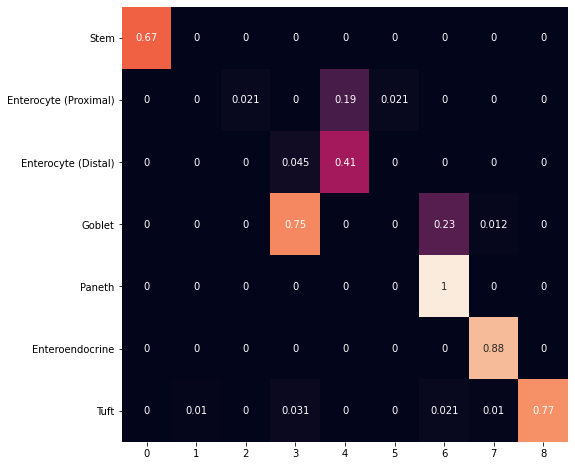

In [51]:
cell_annotation_norm = sc.tl.marker_gene_overlap(adata, marker_genes, key='rank_genes_r0.5', normalize='reference')
sb.heatmap(cell_annotation_norm, cbar=False, annot=True)

In [52]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


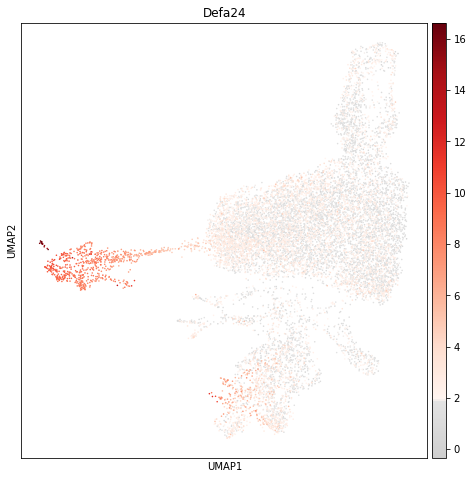

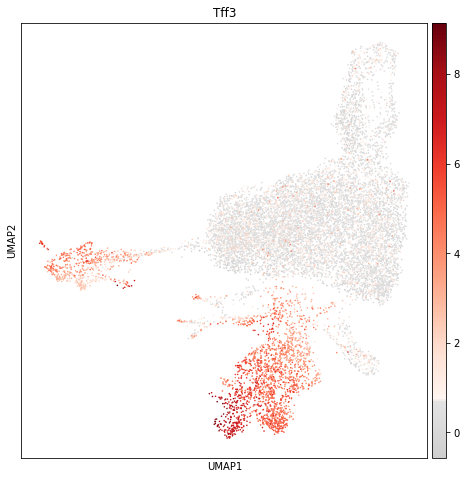

In [53]:
#Defa24 #Tff3
sc.pl.umap(adata, color='Defa24', use_raw=False, color_map=mymap)
sc.pl.umap(adata, color='Tff3', use_raw=False, color_map=mymap)

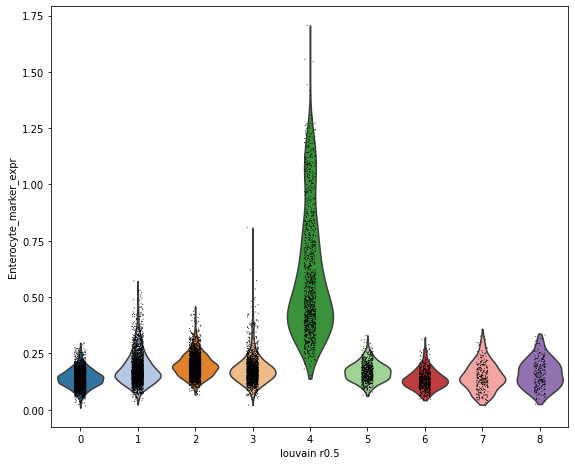

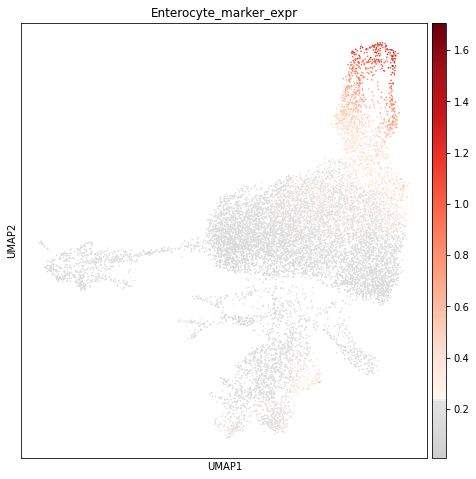

In [54]:
# Check expression of enterocyte markers
#Collate all enterocyte markers and get the gene IDs in the data set
ids_entprox = np.in1d(adata.var_names, marker_genes['Enterocyte (Proximal)'])
ids_entdist = np.in1d(adata.var_names, marker_genes['Enterocyte (Distal)'])
ids_ent = np.logical_or(ids_entprox, ids_entdist)

#Calculate the mean expression of enterocyte markers
adata.obs['Enterocyte_marker_expr'] = adata.X[:,ids_ent].mean(1)

#Plot enterocyte expression
sc.pl.violin(adata, 'Enterocyte_marker_expr', groupby='louvain_r0.5')
sc.pl.umap(adata, color='Enterocyte_marker_expr', color_map=mymap)


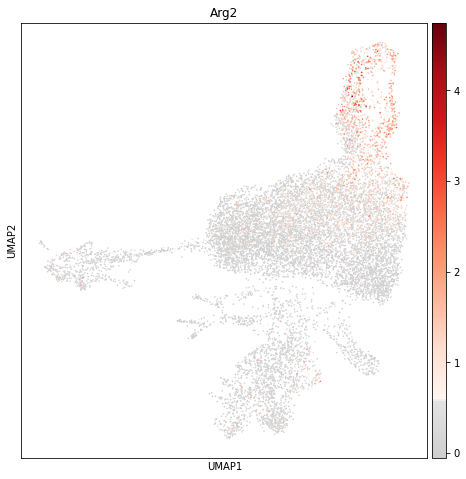

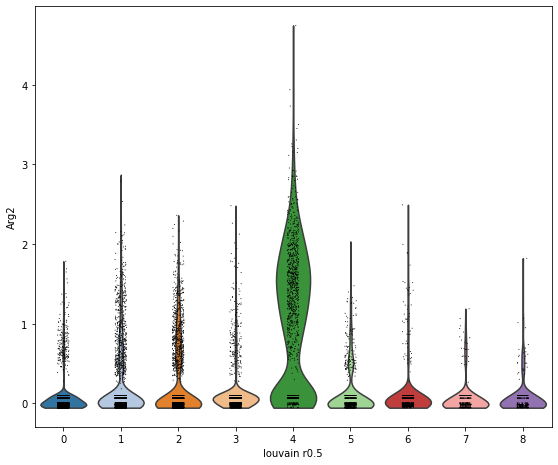

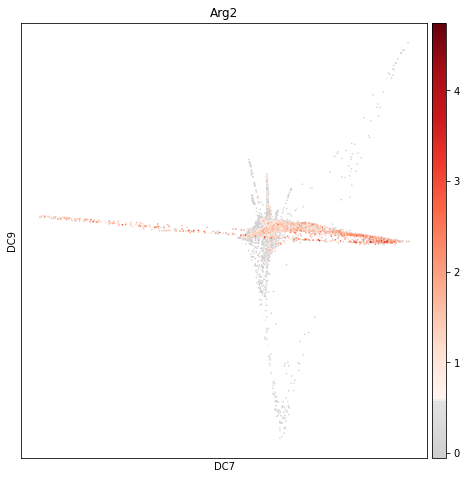

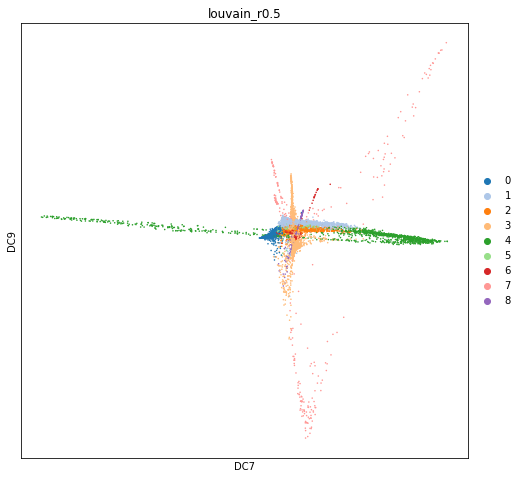

In [55]:
#Early enterocyte marker - Arg2
sc.pl.umap(adata, color='Arg2', use_raw=False, color_map=mymap)

sc.pl.violin(adata, groupby='louvain_r0.5', keys='Arg2', use_raw=False)

sc.pl.diffmap(adata, components=['7,9'], color='Arg2', use_raw=False, color_map=mymap)
sc.pl.diffmap(adata, components=['7,9'], color='louvain_r0.5')

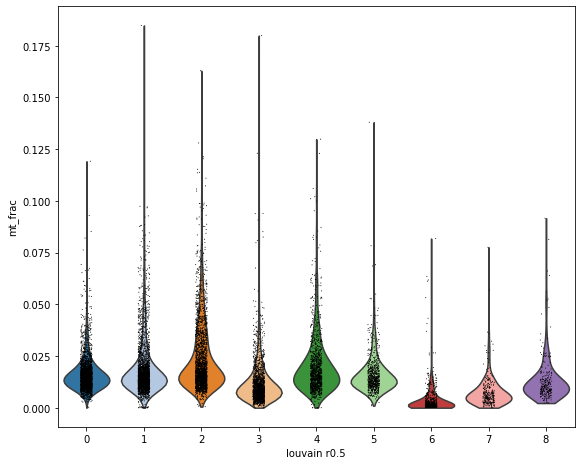

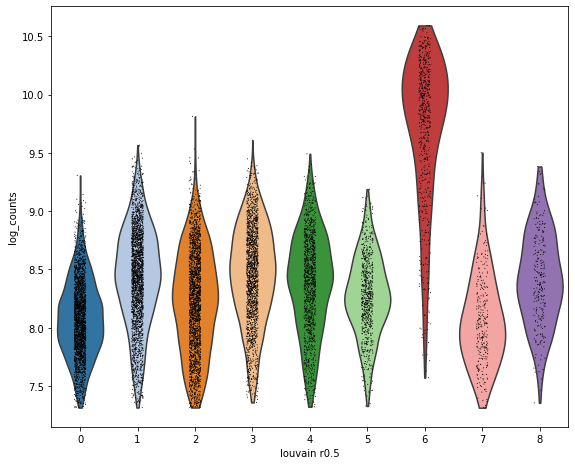

In [56]:
sc.pl.violin(adata, 'mt_frac', groupby='louvain_r0.5')
sc.pl.violin(adata, 'log_counts', groupby='louvain_r0.5')

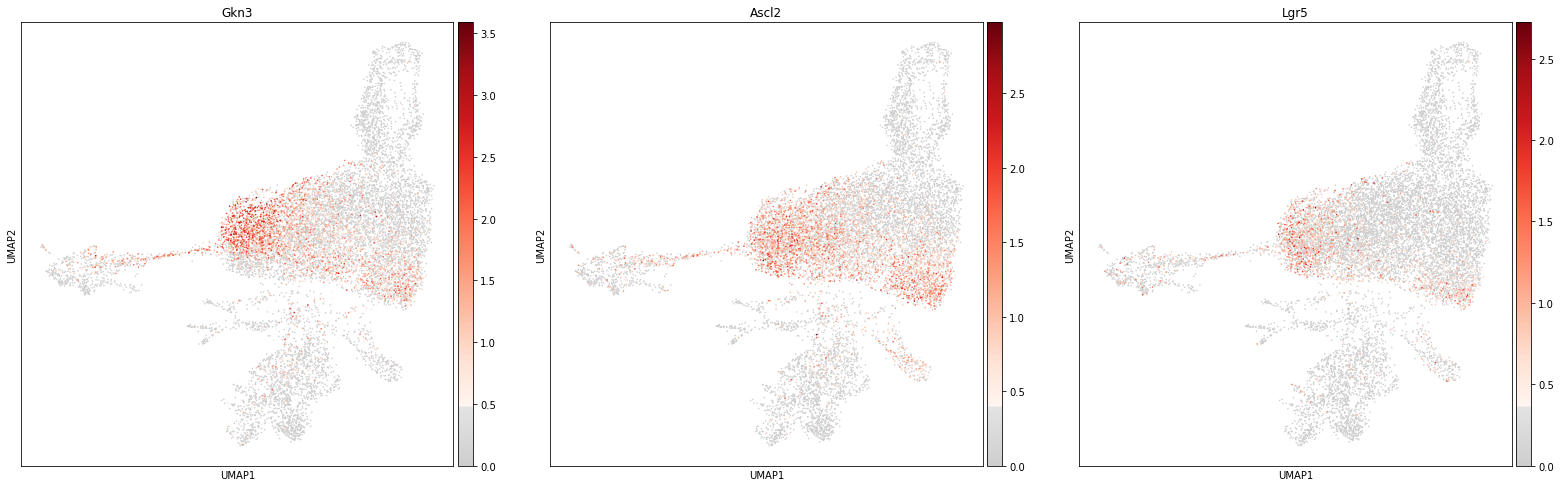

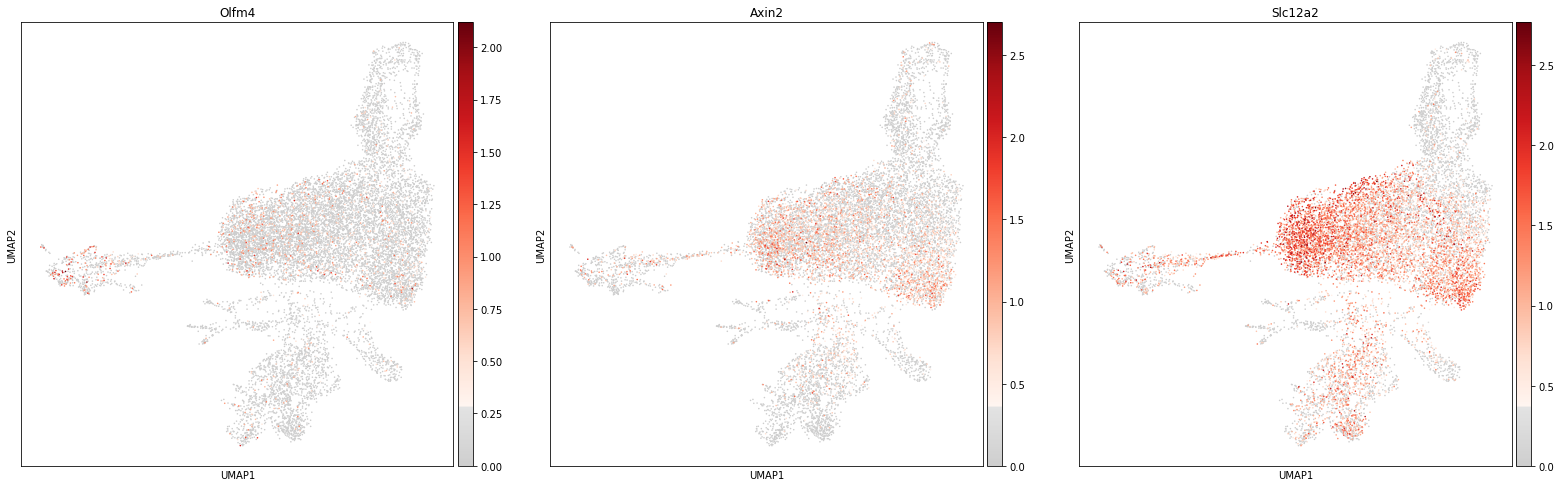

In [57]:
#Check individual stem markers
stem_genes = adata.var_names[np.in1d(adata.var_names, marker_genes['Stem'])]
sc.pl.umap(adata, color=stem_genes[:3], title=stem_genes[:3], color_map=mymap)
sc.pl.umap(adata, color=stem_genes[3:], title=stem_genes[3:], color_map=mymap)

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


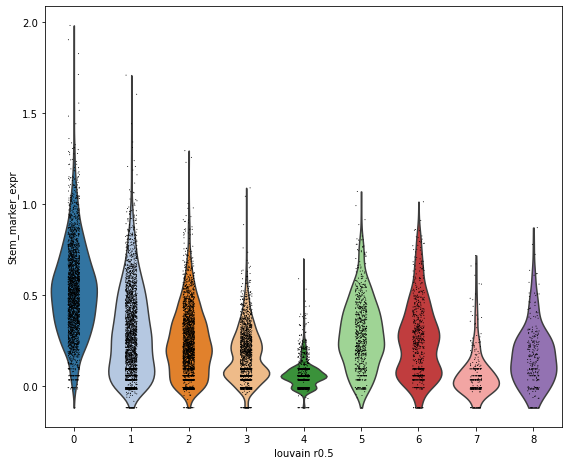

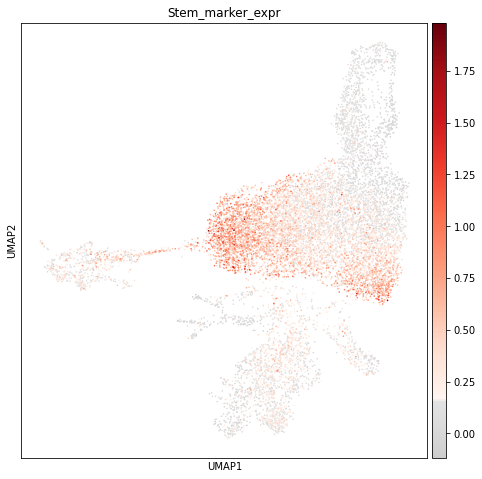

In [58]:
#Check stem marker expression
adata.obs['Stem_marker_expr'] = adata[:,stem_genes].X.mean(1)

sc.pl.violin(adata, 'Stem_marker_expr', groupby='louvain_r0.5')
sc.pl.umap(adata, color='Stem_marker_expr', color_map=mymap)

In [59]:
#Categories to rename
adata.obs['louvain_r0.5'].cat.categories

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8'], dtype='object')

In [61]:
adata.rename_categories('louvain_r0.5', ['EP (stress)', 'Stem', 'EP (early)', 'Goblet', 'TA', 'Enterocyte', 'Paneth', 'Enteroendocrine', 'Tuft'])

In [62]:
adata.obs['louvain_r0.5'].value_counts()

EP (stress)        2577
Stem               2562
EP (early)         2364
Goblet             1803
TA                 1218
Enterocyte          747
Paneth              641
Enteroendocrine     288
Tuft                257
Name: louvain_r0.5, dtype: int64

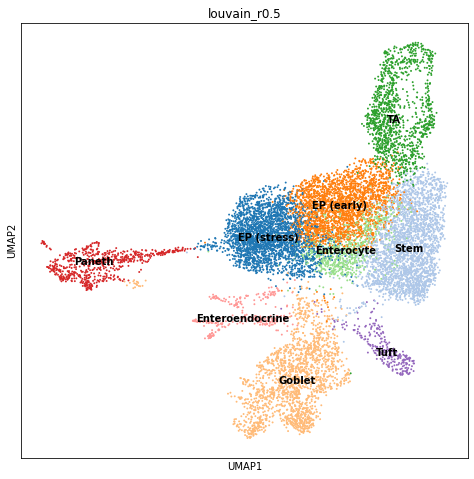

In [63]:
sc.pl.umap(adata, color='louvain_r0.5', size=15, legend_loc='on data')

### 3.3 Subclustering

#### 本案例主要对'Enterocyte'类进行子聚类(Subclustering)分析来探究该类别的子结构，看看是否能找到远端和近端的肠细胞簇。

In [119]:
#Subcluster enterocytes
####################################
##########################################
###更改resolution，将其改为0.5，值越大意味着可以找到更多更小的集群。
####作者将其设为0.2
sc.tl.louvain(adata, restrict_to=('louvain_r0.5', ['Enterocyte']), resolution=0.5, key_added='louvain_r0.5_entero_sub')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'louvain_r0.5_entero_sub', the cluster labels (adata.obs, categorical) (0:00:00)


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


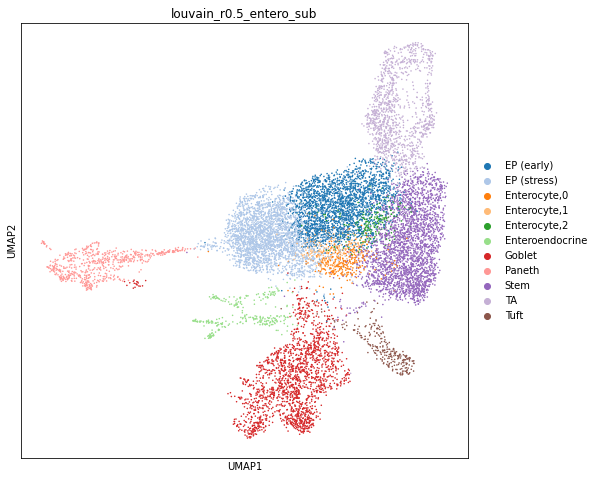

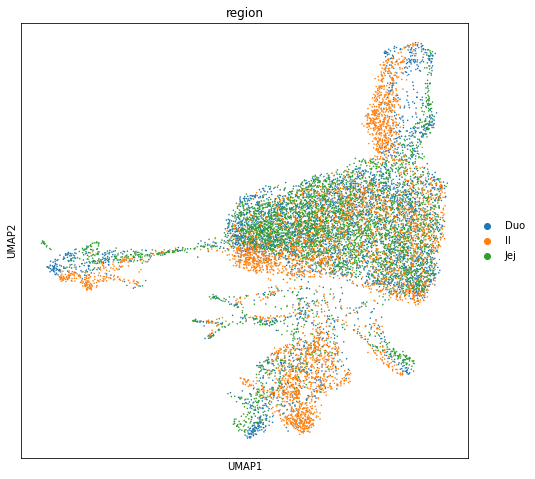

In [120]:
#Show the new clustering
if 'louvain_r0.5_entero_sub_colors' in adata.uns:
    del adata.uns['louvain_r0.5_entero_sub_colors']
######################################################
#######################################################
####删除了palette=sc.pl.palettes.godsnot_64
sc.pl.umap(adata, color='louvain_r0.5_entero_sub',palette=sc.pl.palettes.vega_20)
sc.pl.umap(adata, color='region')

In [121]:
#Get the new marker genes
sc.tl.rank_genes_groups(adata, groupby='louvain_r0.5_entero_sub', key_added='rank_genes_r0.5_entero_sub')

ranking genes
    finished: added to `.uns['rank_genes_r0.5_entero_sub']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:08)


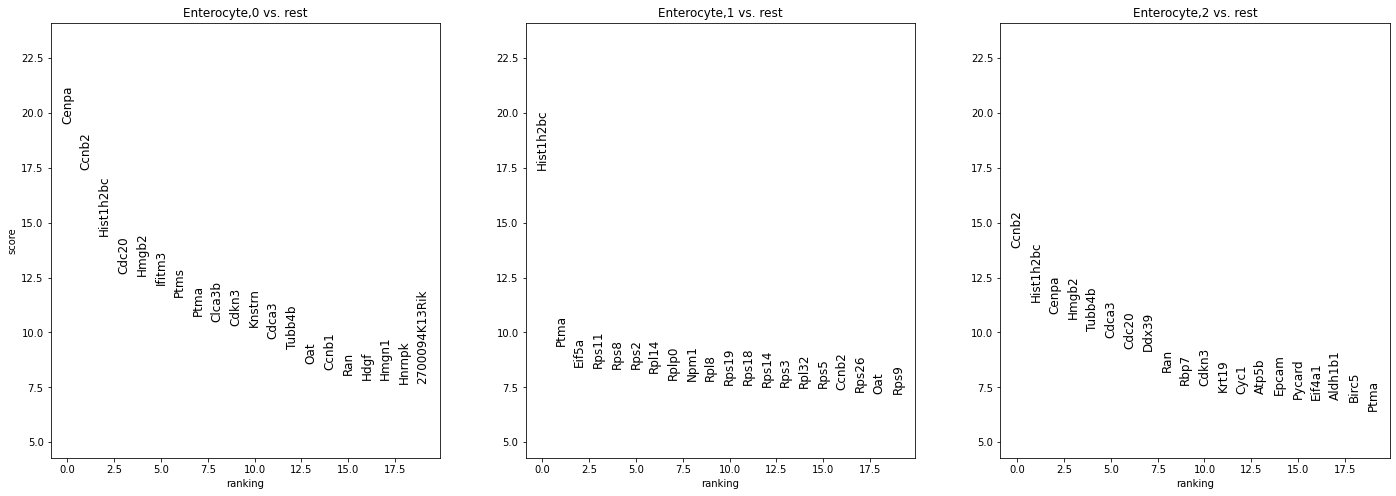

In [122]:
#Plot the new marker genes
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.5_entero_sub', groups=['Enterocyte,0','Enterocyte,1','Enterocyte,2'], fontsize=12)

In [123]:
entero_clusts = [clust for clust in adata.obs['louvain_r0.5_entero_sub'].cat.categories if clust.startswith('Enterocyte')]

In [124]:
entero_clusts

['Enterocyte,0', 'Enterocyte,1', 'Enterocyte,2']

In [125]:
len(adata.uns['rank_genes_r0.5_entero_sub']['names'][clust])

100

In [126]:
adata.uns['rank_genes_r0.5_entero_sub']['names'][clust]

array(['Cenpa', 'Ccnb2', 'Hist1h2bc', 'Cdc20', 'Hmgb2', 'Ifitm3', 'Ptms',
       'Ptma', 'Clca3b', 'Cdkn3', 'Knstrn', 'Cdca3', 'Tubb4b', 'Oat',
       'Ccnb1', 'Ran', 'Hdgf', 'Hmgn1', 'Hnrnpk', '2700094K13Rik',
       'Hmgb3', 'Ifitm2', 'Eif4a1', 'Birc5', 'Cnbp', 'Amica1', 'Cdca8',
       'Dynll1', 'Hist1h1c', 'Cnn3', 'Lsm4', 'Hist1h4i', 'Ccdc34',
       'Ddx39b', 'Hnrnpa2b1', 'Ddx39', 'Cdo1', 'Hsp90ab1', 'Anp32b',
       'Exosc8', 'C1qbp', 'Cdca7', 'Lockd', 'H2afv', 'Srsf5', 'Npm1',
       'Rdm1', 'Nudcd2', '2610318N02Rik', 'Ncl', 'Serbp1', 'Nucks1',
       'Jun', 'H2afz', 'Rad21', 'Cd81', 'Cep89', 'Ilf2', 'Apex1', 'Sox4',
       'Hist3h2a', 'Hnrnpdl', 'Prmt1', 'Hnrnpu', 'Eif5a', 'Bzw1', 'Sypl',
       'Dhrs4', '1500015A07Rik', 'Srsf2', 'Dnajc8', 'Rps3', 'Nde1',
       'Emg1', 'Snrpa1', 'Nup37', 'Snrpf', 'Vdac1', 'Ddit4', 'Ddx5',
       'Nhp2', 'Efna1', 'Npm3', 'Rnaseh2c', 'Cenpw', 'Rps5', 'Zfos1',
       'Gar1', 'Cfl1', 'Ckb', 'Gcat', 'Mad2l1', 'Hspa8', 'Oaz1', 'Cps1',
       'Cct4',

#### 报错：在画小提琴图(sc.pl.rank_genes_groups_violin)时报错，Data must be 1-dimensional

In [ ]:
for clust in entero_clusts:
    sc.pl.rank_genes_groups_violin(adata, use_raw=True, key='rank_genes_r0.5_entero_sub', groups=[clust], gene_names=adata.uns['rank_genes_r0.5_entero_sub']['names'][clust][90:100])

In [128]:
#Subset marker gene dictionary to only check for enterocyte markers
marker_genes_entero = {k: marker_genes[k] for k in marker_genes if k.startswith('Enterocyte')}

In [129]:
#Find marker overlap
sc.tl.marker_gene_overlap(adata, marker_genes_entero, key='rank_genes_r0.5_entero_sub', normalize='reference')

EP (early)  EP (stress)  Enterocyte,0  Enterocyte,1  \
Enterocyte (Proximal)    0.020833          0.0      0.020833      0.020833   
Enterocyte (Distal)      0.000000          0.0      0.000000      0.000000   

                       Enterocyte,2  Enteroendocrine    Goblet  Paneth  Stem  \
Enterocyte (Proximal)      0.020833              0.0  0.000000     0.0   0.0   
Enterocyte (Distal)        0.000000              0.0  0.045455     0.0   0.0   

                             TA  Tuft  
Enterocyte (Proximal)  0.187500   0.0  
Enterocyte (Distal)    0.409091   0.0

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


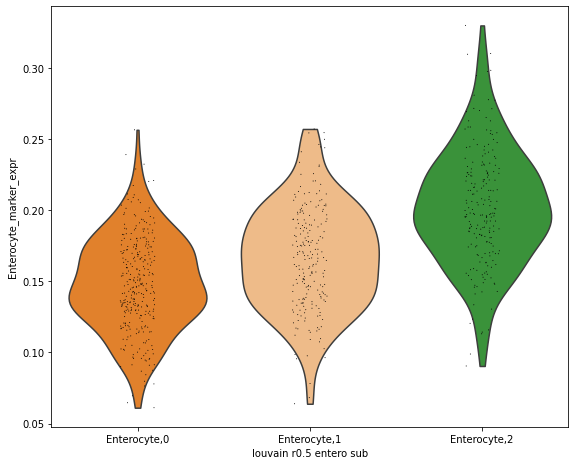

In [130]:
#Check enterocyte marker expression
sc.pl.violin(adata[adata.obs['louvain_r0.5']=='Enterocyte'], groupby='louvain_r0.5_entero_sub', keys='Enterocyte_marker_expr')

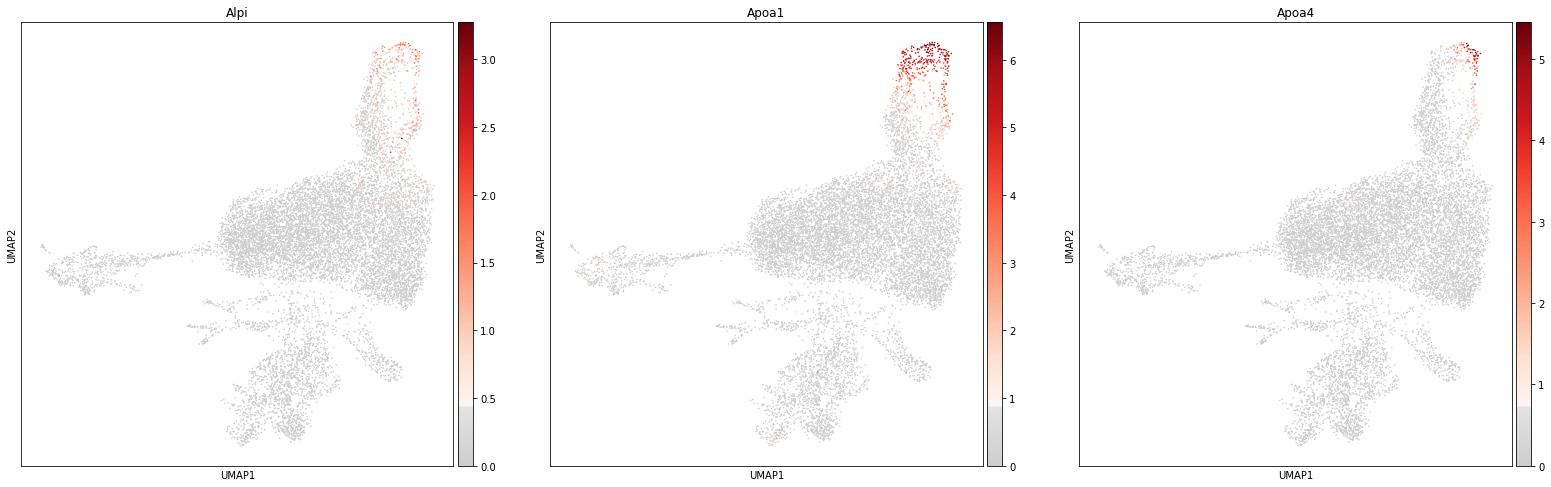

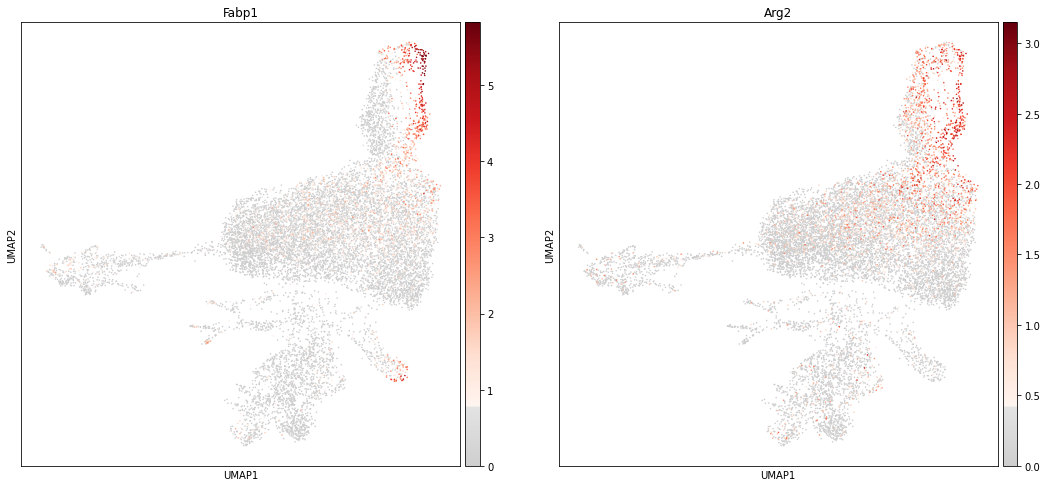

In [131]:
#Visualize some enterocyte markers
entero_genes = ['Alpi', 'Apoa1', 'Apoa4', 'Fabp1', 'Arg2']
sc.pl.umap(adata, color=entero_genes[:3], title=entero_genes[:3], color_map=mymap)
sc.pl.umap(adata, color=entero_genes[3:], title=entero_genes[3:], color_map=mymap)

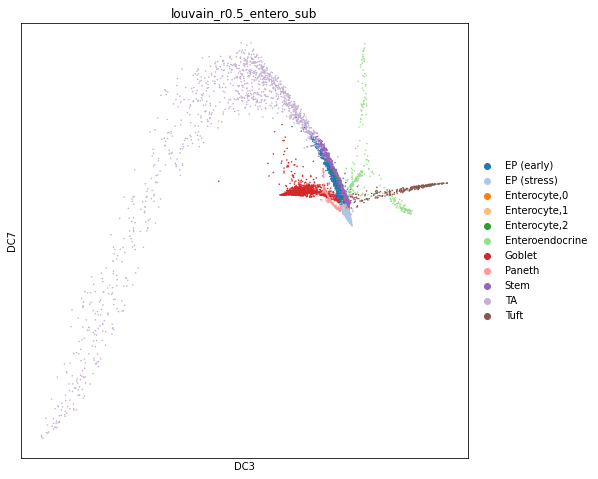

In [132]:
sc.pl.diffmap(adata, color='louvain_r0.5_entero_sub', components='3,7')

In [133]:
tmp = adata.obs['louvain_r0.5_entero_sub'].cat.categories

tmp = ['Enterocyte imm. (Distal)' if item == 'Enterocyte,0' else item for item in tmp]
tmp = ['Enterocyte imm. (Proximal)' if item == 'Enterocyte,1' else item for item in tmp]
tmp = ['Enterocyte mature' if item == 'Enterocyte,2' else item for item in tmp]


adata.rename_categories('louvain_r0.5_entero_sub', tmp)

In [134]:
#Subcluster mature enterocytes
#########################################
#################################
##更改resolution=0.4
sc.tl.louvain(adata, restrict_to=('louvain_r0.5_entero_sub', ['Enterocyte mature']), resolution=0.4, key_added='louvain_r0.5_entero_mat_sub')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain_r0.5_entero_mat_sub', the cluster labels (adata.obs, categorical) (0:00:00)


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


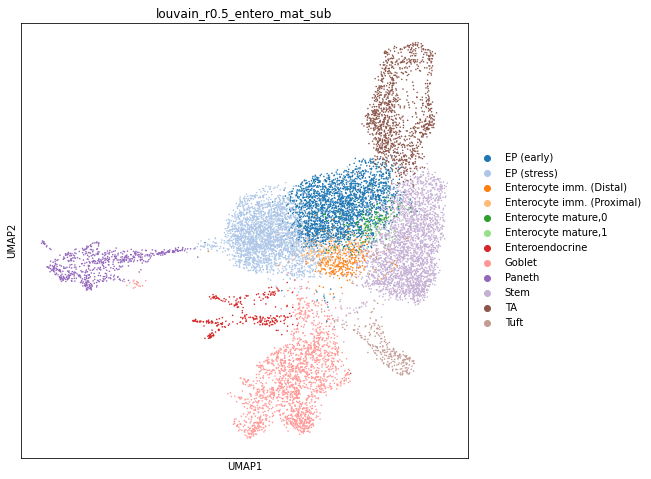

In [135]:
#Show the new clustering
if 'louvain_r0.5_entero_mat_sub_colors' in adata.uns:
    del adata.uns['louvain_r0.5_entero_mat_sub_colors']

sc.pl.umap(adata, color='louvain_r0.5_entero_mat_sub', palette=sc.pl.palettes.vega_20)

In [136]:
#Get the new marker genes
sc.tl.rank_genes_groups(adata, groupby='louvain_r0.5_entero_mat_sub', key_added='rank_genes_r0.5_entero_mat_sub')

ranking genes
    finished: added to `.uns['rank_genes_r0.5_entero_mat_sub']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:08)


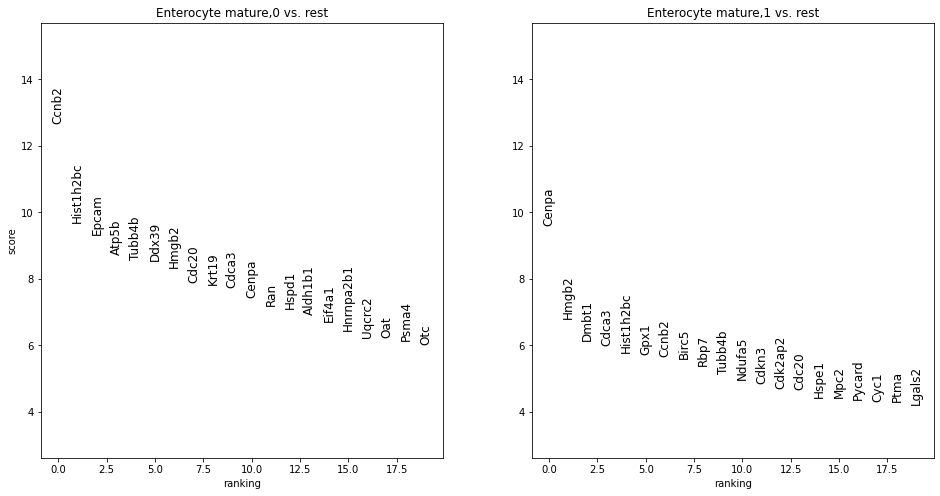

In [137]:
#Plot the new marker genes
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.5_entero_mat_sub', groups=['Enterocyte mature,0','Enterocyte mature,1'], fontsize=12)

In [138]:
entero_mat_clusts = [clust for clust in adata.obs['louvain_r0.5_entero_mat_sub'].cat.categories if clust.startswith('Enterocyte mature')]

In [139]:
entero_mat_clusts

['Enterocyte mature,0', 'Enterocyte mature,1']

#### 报错：在画小提琴图(sc.pl.rank_genes_groups_violin)时报错，Data must be 1-dimensional

In [ ]:
for clust in entero_mat_clusts:
    sc.pl.rank_genes_groups_violin(adata, use_raw=True, key='rank_genes_r0.5_entero_mat_sub', groups=[clust], gene_names=adata.uns['rank_genes_r0.5_entero_mat_sub']['names'][clust][90:100])

In [141]:
#Find marker overlap
sc.tl.marker_gene_overlap(adata, marker_genes_entero, key='rank_genes_r0.5_entero_mat_sub', normalize='reference')

EP (early)  EP (stress)  Enterocyte imm. (Distal)  \
Enterocyte (Proximal)    0.020833          0.0                  0.020833   
Enterocyte (Distal)      0.000000          0.0                  0.000000   

                       Enterocyte imm. (Proximal)  Enterocyte mature,0  \
Enterocyte (Proximal)                    0.020833             0.020833   
Enterocyte (Distal)                      0.000000             0.000000   

                       Enterocyte mature,1  Enteroendocrine    Goblet  Paneth  \
Enterocyte (Proximal)             0.020833              0.0  0.000000     0.0   
Enterocyte (Distal)               0.000000              0.0  0.045455     0.0   

                       Stem        TA  Tuft  
Enterocyte (Proximal)   0.0  0.187500   0.0  
Enterocyte (Distal)     0.0  0.409091   0.0

In [142]:
tmp = adata.obs['louvain_r0.5_entero_mat_sub'].cat.categories

tmp = ['Enterocyte mat. (Distal)' if item == 'Enterocyte mature,0' else item for item in tmp]
tmp = ['Enterocyte mat. (Proximal)' if item == 'Enterocyte mature,1' else item for item in tmp]

adata.rename_categories('louvain_r0.5_entero_mat_sub', tmp)

In [143]:
adata.obs['louvain_final'] = adata.obs['louvain_r0.5_entero_mat_sub']

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


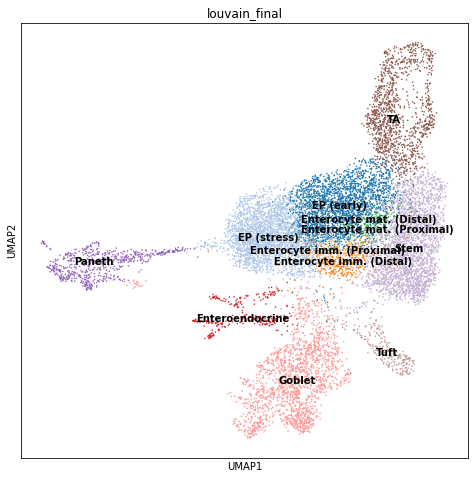

In [144]:
sc.pl.umap(adata, color='louvain_final', palette=sc.pl.palettes.vega_20, legend_loc='on data')

In [145]:
adata.obs['louvain_final'].value_counts()

EP (stress)                   2577
Stem                          2562
EP (early)                    2364
Goblet                        1803
TA                            1218
Paneth                         641
Enterocyte imm. (Distal)       318
Enteroendocrine                288
Tuft                           257
Enterocyte imm. (Proximal)     217
Enterocyte mat. (Distal)       156
Enterocyte mat. (Proximal)      56
Name: louvain_final, dtype: int64

### 3.4 Compositional analysis

#### 细胞组成数据分析围绕不同样品落入每个细胞簇的细胞比例进行分析。这一比例可能在疾病状态下发生变化。

#### 例如，沙门氏菌感染已显示会增加小鼠肠上皮中肠上皮细胞的比例。

In [146]:
#Define a variable that stores proximal and distal labels
adata.obs['prox_dist'] = ['Distal' if reg=='Il' else 'Proximal' for reg in adata.obs['region']]

In [147]:
sc.tl.embedding_density(adata, basis='umap', groupby='prox_dist')

... storing 'prox_dist' as categorical


computing density on 'umap'
--> added
    'umap_density_prox_dist', densities (adata.obs)
    'umap_density_prox_dist_params', parameter (adata.uns)


/usr/local/lib/python3.6/dist-packages/scanpy/plotting/_tools/__init__.py:979: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("YlOrRd"))
  color_map.set_over('black')
/usr/local/lib/python3.6/dist-packages/scanpy/plotting/_tools/__init__.py:980: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("YlOrRd"))
  color_map.set_under('lightgray')
/usr/local/lib/python3.6/dist-packages/scanpy/plotting/_tools/scatterplots.py:400: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will beco

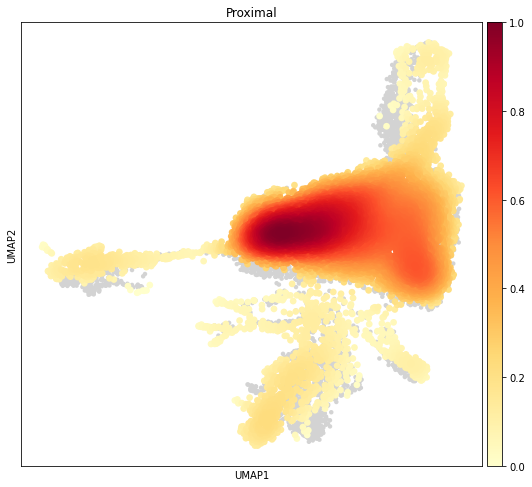

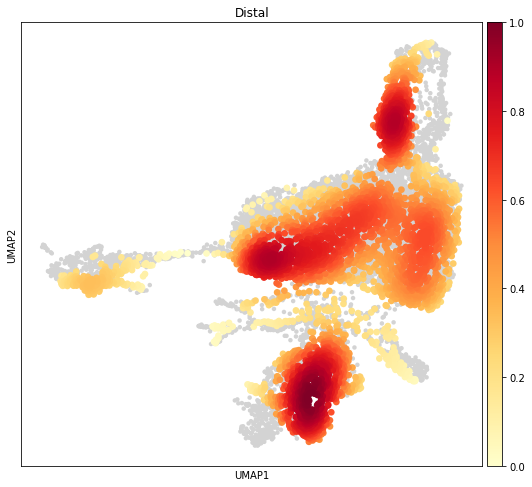

In [148]:
adata.obs['prox_dist'].value_counts()
sc.pl.embedding_density(adata, basis='umap', key='umap_density_prox_dist', group='Proximal')
sc.pl.embedding_density(adata, basis='umap', key='umap_density_prox_dist', group='Distal')

### 3.5 Trajectory inference and pseudotime analysis

#### 推断细胞发育轨迹--比如细胞内的动态过程(如细胞周期、细胞分化和细胞激活等)

#### 由于轨迹推断是一个尚未解决的复杂问题，因此选择了三种方法(“Slingshot”、“Monocle2”和“Diffsion Pseudotime(DPT)”)

In [149]:
adata.obs['louvain_final'].value_counts()

EP (stress)                   2577
Stem                          2562
EP (early)                    2364
Goblet                        1803
TA                            1218
Paneth                         641
Enterocyte imm. (Distal)       318
Enteroendocrine                288
Tuft                           257
Enterocyte imm. (Proximal)     217
Enterocyte mat. (Distal)       156
Enterocyte mat. (Proximal)      56
Name: louvain_final, dtype: int64

In [150]:
#Subsetting to relevant clusters
clusters_to_include = [g for g in adata.obs['louvain_final'].cat.categories if (g.startswith('Enterocyte') or g.startswith('TA') or g.startswith('Stem') or g.startswith('EP'))]
adata_ent = adata[np.isin(adata.obs['louvain_final'], clusters_to_include),:]

#Subset to highly variable genes
sc.pp.highly_variable_genes(adata_ent, flavor='cell_ranger', n_top_genes=4000, subset=True)

extracting highly variable genes


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


Trying to set attribute `.var` of view, copying.
/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


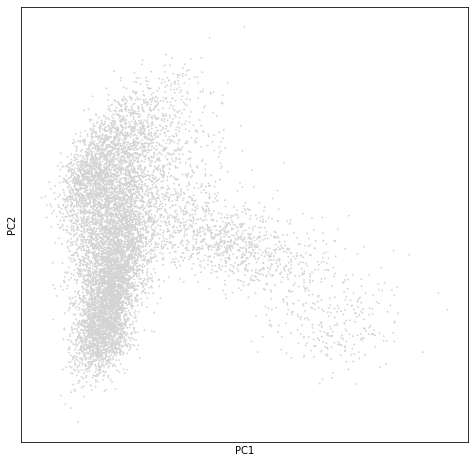

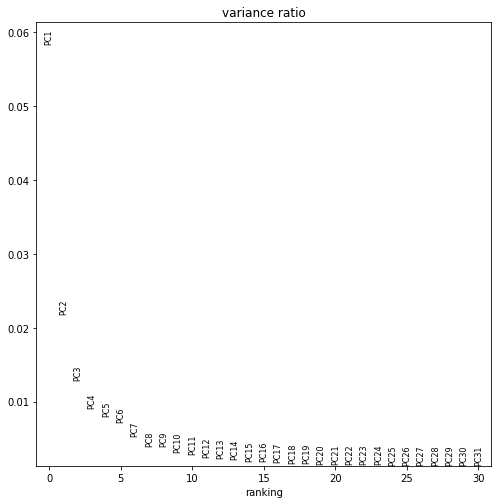

In [151]:
#Recalculating PCA for subset
sc.pp.pca(adata_ent, svd_solver='arpack')
sc.pl.pca(adata_ent)
sc.pl.pca_variance_ratio(adata_ent)

In [152]:
adata_ent.obsm['X_pca'] = adata_ent.obsm['X_pca'][:,0:7]

### 3.5.1 Slingshot

In [153]:
#Preprocessing for slingshot
data_mat = adata_ent.X.T
obs = adata_ent.obs
var = adata_ent.var
pca_x = adata_ent.obsm['X_pca'][:,0:7]
dm_x = adata_ent.obsm['X_diffmap']

[1] "1:"
class: SlingshotDataSet 

 Samples Dimensions
    9468          7

lineages: 2 
Lineage1: Stem  Enterocyte mat. (Proximal)  Enterocyte mat. (Distal)  Enterocyte imm. (Distal)  Enterocyte imm. (Proximal)  EP (early)  TA  
Lineage2: Stem  Enterocyte mat. (Proximal)  Enterocyte mat. (Distal)  Enterocyte imm. (Distal)  Enterocyte imm. (Proximal)  EP (early)  EP (stress)  

curves: 2 
Curve1: Length: 37.392	Samples: 6529.74
Curve2: Length: 18.836	Samples: 8118.57
[1] ""
[1] "2:"
class: SlingshotDataSet 

 Samples Dimensions
    9468          7

lineages: 4 
Lineage1: Stem  EP (early)  Enterocyte imm. (Proximal)  Enterocyte imm. (Distal)  Enterocyte mat. (Distal)  
Lineage2: Stem  EP (early)  TA  
Lineage3: Stem  EP (early)  EP (stress)  
Lineage4: Stem  Enterocyte mat. (Proximal)  

curves: 4 
Curve1: Length: 21.184	Samples: 5343.07
Curve2: Length: 39.832	Samples: 5233.24
Curve3: Length: 20.14	Samples: 6906.05
Curve4: Length: 16.521	Samples: 2960.85
[1] ""
[1] "3:"
class: Slingshot

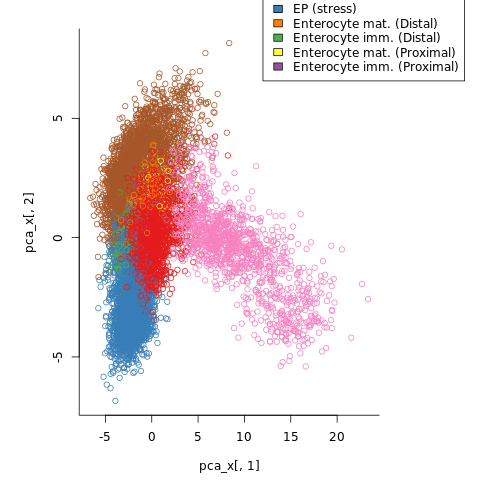

In [154]:
%%R -i data_mat -i obs -i var -i pca_x -i dm_x -o sce_start -o sce_startend -o sce_simple_startend
library(slingshot)
library(RColorBrewer)

#Create the SingleCellExperiment data structure
sce <- SingleCellExperiment(assays=data_mat, rowData=var, colData=obs)

#Load the dimensionality reduced data
reducedDims(sce) <- SimpleList(PCA = pca_x, DM = dm_x)

#Plot 1
colour_map = brewer.pal(20,'Set1')
par(xpd=TRUE)
par(mar=c(4.5,5.5,2,7))
plot(pca_x[,1], pca_x[,2], col=colour_map[colData(sce)$louvain_final], bty='L')
legend(x=12, y=12, legend=unique(colData(sce)$louvain_final), fill=colour_map[as.integer(unique(colData(sce)$louvain_final))])

print("1:")
sce_start <- slingshot(sce, clusterLabels = 'louvain_final', reducedDim = 'PCA', start.clus='Stem')
print(SlingshotDataSet(sce_start))

print("")
print("2:")
sce_startend <- slingshot(sce, clusterLabels = 'louvain_final', reducedDim = 'PCA', start.clus='Stem', end.clus=c('Enterocyte mat. (Proximal)', 'Enterocyte mat. (Distal)'))
print(SlingshotDataSet(sce_startend))

print("")
print("3:")
sce_simple_startend <- slingshot(sce, clusterLabels = 'louvain_r0.5', reducedDim = 'PCA', start.clus='Stem', end.clus='Enterocyte')
print(SlingshotDataSet(sce_simple_startend))

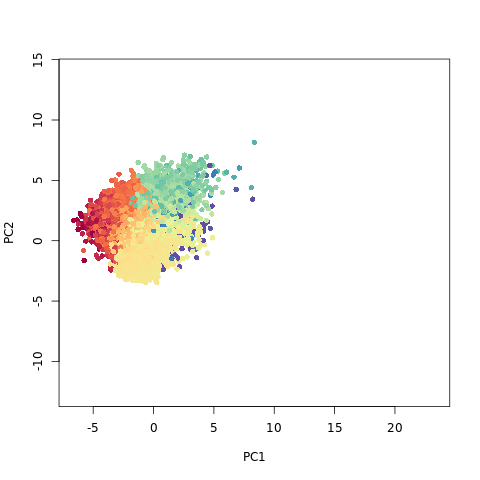

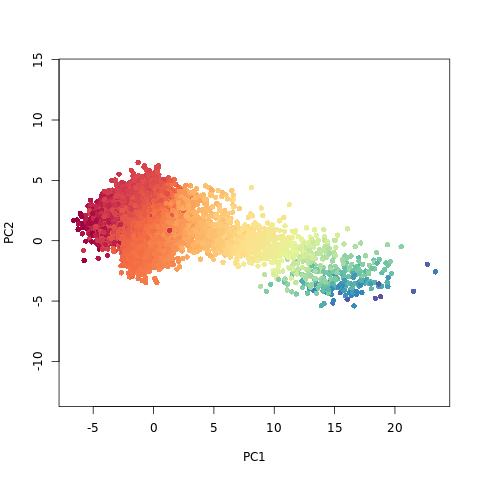

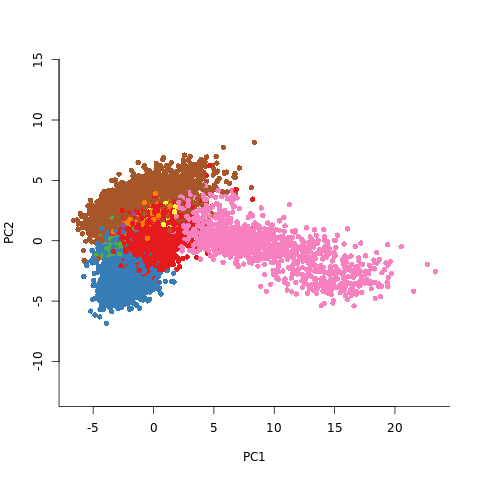

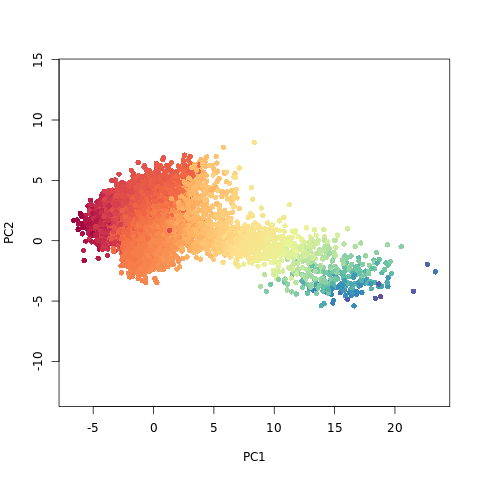

In [156]:
%%R -i sce_startend -i sce_simple_startend

library(slingshot)
library(RColorBrewer)


#Plot of lineage 1
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(sce_startend)$PCA[,c(1,2)], col = colors[cut(sce_startend$slingPseudotime_1,breaks=100)], pch=16, asp = 1, xlab='PC1', ylab='PC2')
#lines(slingCurves(sce_startend)$curve1, lwd=2)

#Plot of lineage 2
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(sce_startend)$PCA[,c(1,2)], col = colors[cut(sce_startend$slingPseudotime_2,breaks=100)], pch=16, asp = 1, xlab='PC1', ylab='PC2')
# lines(slingCurves(sce_startend)$curve2, lwd=2)


#Plot of lineages with clusters visualized
par(xpd=TRUE)
plot(reducedDims(sce_startend)$PCA[,c(1,2)], col = brewer.pal(11,'Set1')[sce$louvain_final], pch=16, asp = 1, bty='L', xlab='PC1', ylab='PC2')
# lines(SlingshotDataSet(sce_startend), lwd=2, type='lineages')
# legend(x=10, y=20, legend=unique(colData(sce)$louvain_final), fill=brewer.pal(11,'Set1')[as.integer(unique(colData(sce)$louvain_final))])


# #Plot of simpler clustering
plot(reducedDims(sce_simple_startend)$PCA[,c(1,2)], col = colors[cut(sce_simple_startend$slingPseudotime_1,breaks=100)], pch=16, asp = 1, xlab='PC1', ylab='PC2')
# lines(SlingshotDataSet(sce_simple_startend), lwd=2)

#### 3.5.2 Non-batch-corrected slingshot 

In [157]:
#Subsetting data set - non-batch corrected
cell_mask = np.isin(adata.obs['louvain_final'], clusters_to_include)
adata_ent_nbc = sc.AnnData(X = adata.raw.X[cell_mask,:])
adata_ent_nbc.obs = adata.obs[cell_mask]
adata_ent_nbc.var = adata.var.copy()

#Subset to highly variable genes
sc.pp.filter_genes_dispersion(adata_ent_nbc, flavor='cell_ranger', n_top_genes=4000, log=False)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99448943 0.98162967 0.972188   0.9692668  0.9600392
     0.9528289  0.94402456 0.9258731  0.9229493  0.9156964  0.90946186
     0.9070218  0.90585065 0.89987975]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


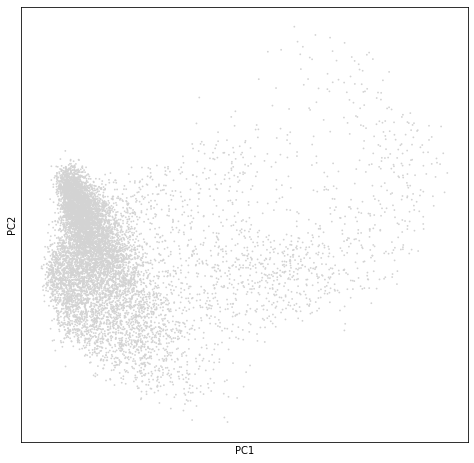

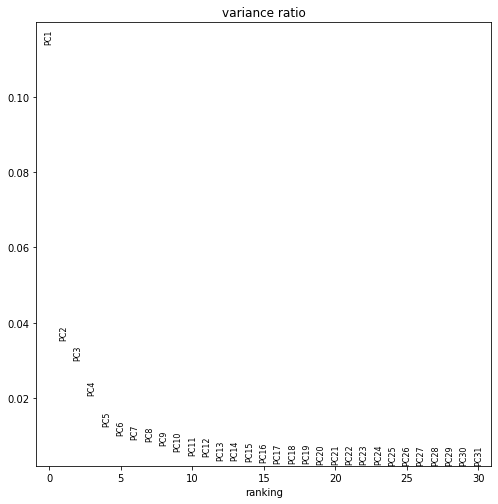

In [158]:
#Recalculating PCA for subset
sc.pp.pca(adata_ent_nbc, svd_solver='arpack')
sc.pp.neighbors(adata_ent_nbc)
sc.tl.diffmap(adata_ent_nbc)
sc.pl.pca(adata_ent_nbc)
sc.pl.pca_variance_ratio(adata_ent_nbc)

In [159]:
#Preprocessing for slingshot - non-batch-corrected
data_mat_nbc = adata_ent_nbc.X.T
obs_nbc = adata_ent_nbc.obs
var_nbc = adata_ent_nbc.var
pca_x_nbc = adata_ent_nbc.obsm['X_pca'][:,0:7]
dm_x_nbc = adata_ent_nbc.obsm['X_diffmap']

[1] "1:"
class: SlingshotDataSet 

 Samples Dimensions
    9468          7

lineages: 2 
Lineage1: Stem  Enterocyte mat. (Proximal)  Enterocyte mat. (Distal)  Enterocyte imm. (Distal)  Enterocyte imm. (Proximal)  EP (early)  TA  
Lineage2: Stem  Enterocyte mat. (Proximal)  Enterocyte mat. (Distal)  Enterocyte imm. (Distal)  Enterocyte imm. (Proximal)  EP (early)  EP (stress)  

curves: 2 
Curve1: Length: 37.392	Samples: 6529.74
Curve2: Length: 18.836	Samples: 8118.57
[1] ""
[1] "2:"
class: SlingshotDataSet 

 Samples Dimensions
    9468          7

lineages: 4 
Lineage1: Stem  Enterocyte imm. (Distal)  Enterocyte imm. (Proximal)  EP (early)  TA  
Lineage2: Stem  Enterocyte imm. (Distal)  Enterocyte imm. (Proximal)  EP (early)  EP (stress)  
Lineage3: Stem  Enterocyte imm. (Distal)  Enterocyte imm. (Proximal)  Enterocyte mat. (Distal)  
Lineage4: Stem  Enterocyte mat. (Proximal)  

curves: 4 
Curve1: Length: 39.792	Samples: 6306.53
Curve2: Length: 20.124	Samples: 7485.31
Curve3: Length:

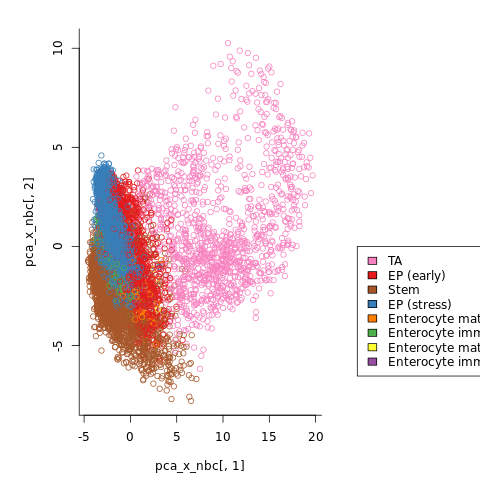

In [160]:
%%R -i data_mat_nbc -i obs_nbc -i var_nbc -i pca_x_nbc -i dm_x_nbc -o sce_start_nbc -o sce_startend_nbc -o sce_simple_startend_nbc
library(slingshot)
library(RColorBrewer)

#Create the SingleCellExperiment data structure
sce <- SingleCellExperiment(assays=data_mat_nbc, rowData=var_nbc, colData=obs_nbc)

#Load the dimensionality reduced data
reducedDims(sce) <- SimpleList(PCA = pca_x_nbc, DM = dm_x_nbc)

#Plot 1
colour_map = brewer.pal(20,'Set1')
par(xpd=TRUE)
par(mar=c(4.5,5.5,2,11))
plot(pca_x_nbc[,1], pca_x_nbc[,2], col=colour_map[colData(sce)$louvain_final], bty='L')
legend(x=24.5, y=0, legend=unique(colData(sce)$louvain_final), fill=colour_map[as.integer(unique(colData(sce)$louvain_final))])

#First trajectory: only Stem cells set as root cells
print("1:")
sce_start_nbc <- slingshot(sce, clusterLabels = 'louvain_final', reducedDim = 'PCA', start.clus='Stem')
print(SlingshotDataSet(sce_start))

#Second trajectory: Stem cells as root cells and mature enterocytes as end clusters
print("")
print("2:")
sce_startend_nbc <- slingshot(sce, clusterLabels = 'louvain_final', reducedDim = 'PCA', start.clus='Stem', end.clus=c('Enterocyte mat. (Proximal)', 'Enterocyte mat. (Distal)'))
print(SlingshotDataSet(sce_startend_nbc))

#Third trajectory: Stem cells as root cells and enterocytes as end cluster, non-subclustered data
print("")
print("3:")
sce_simple_startend_nbc <- slingshot(sce, clusterLabels = 'louvain_r0.5', reducedDim = 'PCA', start.clus='Stem', end.clus='Enterocyte')
print(SlingshotDataSet(sce_simple_startend_nbc))



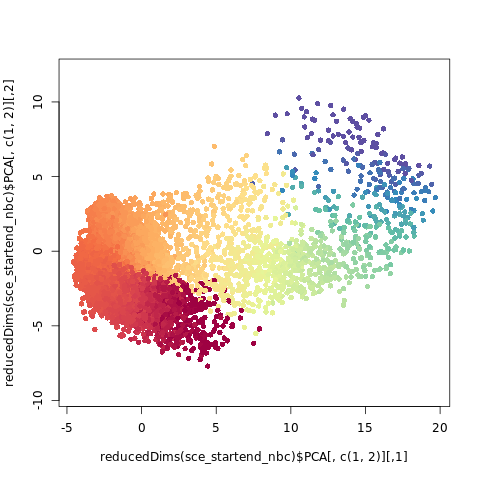

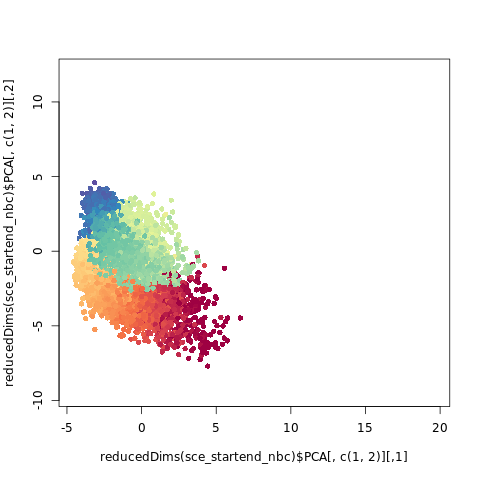

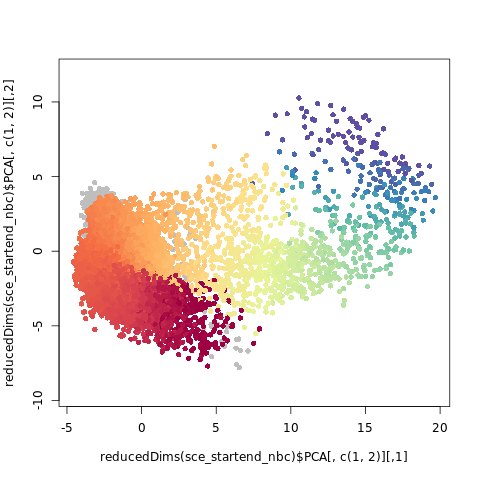

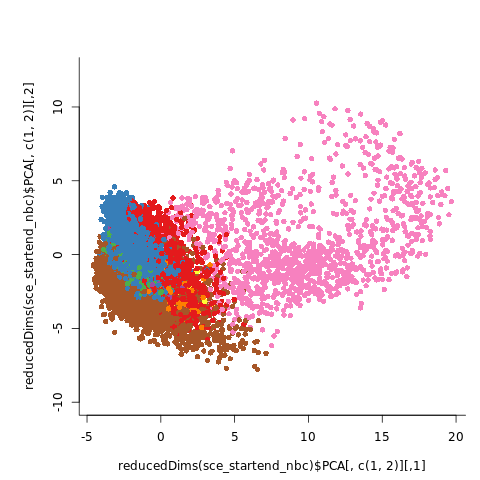

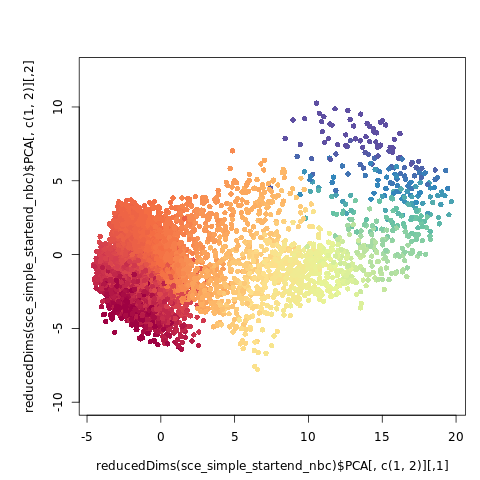

In [161]:
%%R -i sce_startend_nbc -i sce_start_nbc -i sce_simple_startend_nbc
library(RColorBrewer)
library(slingshot)

colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)

#Plot of lineage 1
plot(reducedDims(sce_startend_nbc)$PCA[,c(1,2)], col = colors[cut(sce_startend_nbc$slingPseudotime_1,breaks=100)], pch=16, asp = 1)
# lines(slingCurves(sce_startend_nbc)$curve1, lwd=2)

#Plot of lineage 2
plot(reducedDims(sce_startend_nbc)$PCA[,c(1,2)], col = colors[cut(sce_startend_nbc$slingPseudotime_2,breaks=100)], pch=16, asp = 1)
# lines(slingCurves(sce_startend_nbc)$curve2, lwd=2)

#Combined plot
plot(reducedDims(sce_startend_nbc)$PCA[,c(1,2)], col = 'grey', pch=16, asp = 1, size=0.8)
points(reducedDims(sce_startend_nbc)$PCA[,c(1,2)], col = colors[cut(sce_startend_nbc$slingPseudotime_1,breaks=100)], pch=16, size=1)
# lines(slingCurves(sce_startend_nbc)$curve1, lwd=2)
# lines(slingCurves(sce_startend_nbc)$curve2, lwd=2)

#Plot of lineages with clusters visualized
par(xpd=TRUE)
par(mar=c(4.5,5.5,4,1))
plot(reducedDims(sce_startend_nbc)$PCA[,c(1,2)], col = brewer.pal(11,'Set1')[sce_startend_nbc$louvain_final], pch=16, asp = 1, bty='L')
# lines(SlingshotDataSet(sce_startend_nbc), lwd=2, type='lineages')
# legend(x=6, y=20, legend=unique(colData(sce)$louvain_final), fill=brewer.pal(11,'Set1')[as.integer(unique(colData(sce)$louvain_final))])

#Plot of simpler clustering
plot(reducedDims(sce_simple_startend_nbc)$PCA[,c(1,2)], col = colors[cut(sce_simple_startend_nbc$slingPseudotime_1,breaks=100)], pch=16, asp = 1)
# lines(SlingshotDataSet(sce_simple_startend_nbc), lwd=2)

#### 3.5.3 Monocle2

In [162]:
#Preprocessing for monocle
data_mat_mon = adata.layers['counts'].T
var_mon=adata.var.copy()
obs_mon=adata.obs.copy()

In [220]:
%%R -i data_mat_mon -i obs_mon -i var_mon -o ie_regions_cds -o root_name
library(monocle)

#Set up the CellDataSet data structure
pd <- AnnotatedDataFrame(data = obs_mon)
fd <- AnnotatedDataFrame(data = var_mon)
colnames(data_mat_mon) <- rownames(pd)
rownames(data_mat_mon) <- rownames(fd)
ie_regions_cds <- newCellDataSet(cellData=data_mat_mon, phenoData=pd, featureData=fd, expressionFamily=negbinomial.size())

#Normalize the count data
ie_regions_cds <- estimateSizeFactors(ie_regions_cds)

#Calculate dispersions to filter for highly variable genes
ie_regions_cds <- estimateDispersions(ie_regions_cds)


#Filter for Stem, EP, TA, and Enterocytes
cell_types = as.character(pData(ie_regions_cds)$louvain_final)
cell_mask = rep(FALSE, length(cell_types))
cells_to_keep = c("Stem", "EP", "TA", "Enterocyte")
for (item in cells_to_keep) {cell_mask = cell_mask | startsWith(cell_types, item)}
print("Number of cells after filtering:")
print(sum(cell_mask))
print("")

#Filter highly variable genes from our analysis
hvg_mask = fData(ie_regions_cds)$highly_variable
ie_regions_cds <- ie_regions_cds[hvg_mask, cell_mask]

#Do dimensionality reduction
ie_regions_cds <- reduceDimension(ie_regions_cds, norm_method = 'vstExprs', reduction_method='DDRTree', verbose = F, max_components = 7)

#Run for the first time to get the ordering
ie_regions_cds <- orderCells(ie_regions_cds)

#Find the correct root state the corresponds to the 'Stem' cluster
tab1 <- table(pData(ie_regions_cds)$State, pData(ie_regions_cds)$louvain_final)
id = which(colnames(tab1) == 'Stem')
root_name = names(which.max(tab1[,id]))

#Run a second time to get the correct root state that overlaps with Stem cells
ie_regions_cds <- orderCells(ie_regions_cds, root_state=root_name)

[1] "Number of cells after filtering:"
[1] 9468
[1] ""


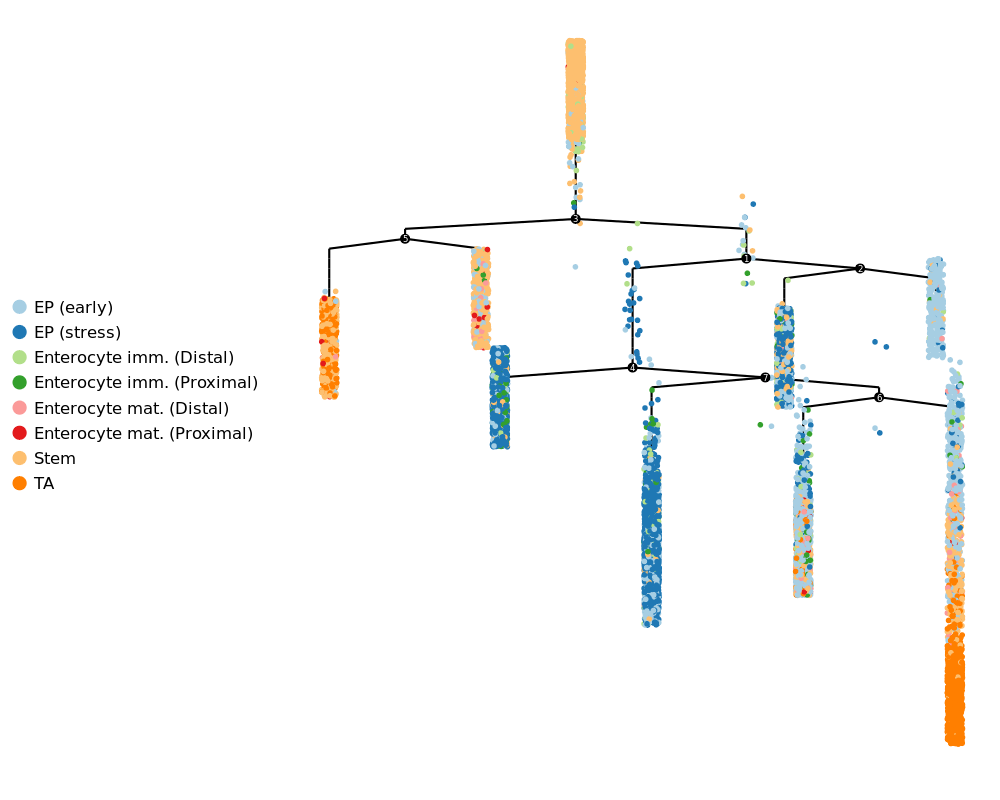

In [221]:
%%R -i ie_regions_cds -w 1000 -h 800
library(monocle)
library(RColorBrewer)

#Get a nice colour map
custom_colour_map = brewer.pal(length(unique(pData(ie_regions_cds)$louvain_final)),'Paired')

#Find the correct root state that coresponds to the 'Stem' cluster
tab1 <- table(pData(ie_regions_cds)$State, pData(ie_regions_cds)$louvain_final)
id = which(colnames(tab1) == 'Stem')
root_name = names(which.max(tab1[,id]))

# Visualize with our cluster labels
options(repr.plot.width=5, repr.plot.height=4)
plot_complex_cell_trajectory(ie_regions_cds, color_by = 'louvain_final', show_branch_points = T, 
                             cell_size = 2, cell_link_size = 1, root_states = c(root_name)) +
scale_size(range = c(0.2, 0.2)) +
theme(legend.position="left", legend.title=element_blank(), legend.text=element_text(size=rel(1.5))) +
guides(colour = guide_legend(override.aes = list(size=6))) + 
scale_color_manual(values = custom_colour_map)

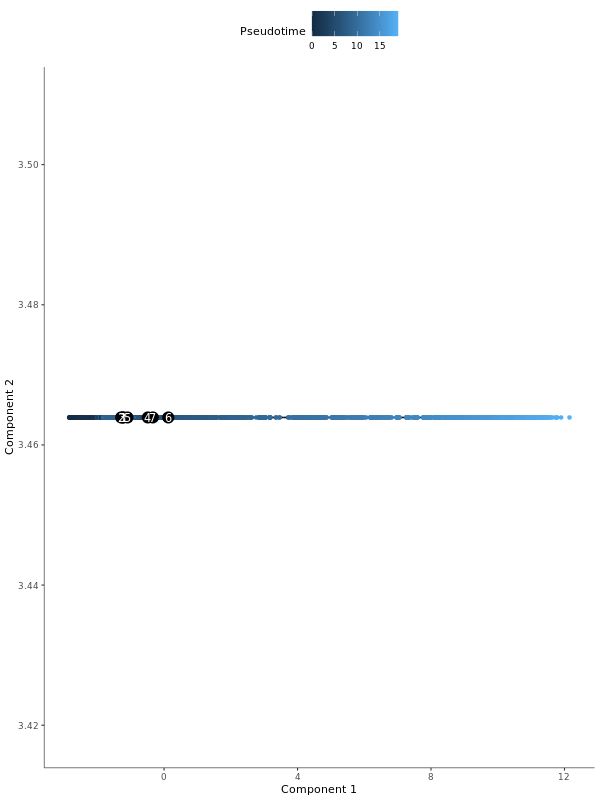

In [222]:
%%R -i ie_regions_cds -w 600 -h 800
library(monocle)

#Visualize pseudotime found
options(repr.plot.width=5, repr.plot.height=4)
plot_cell_trajectory(ie_regions_cds, color_by="Pseudotime")

#### 3.5.4 Diffusion Pseudotime (DPT)

In [166]:
adata_ent.obs

sample region donor  n_counts  log_counts  n_genes   mt_frac  \
AAACATACCTTACT  Duo_M1    Duo    M1    6587.0    8.792853     2156  0.010779   
AAACATACTTTGCT  Duo_M1    Duo    M1    2844.0    7.952967     1424  0.033755   
AAACCGTGCAGTCA  Duo_M1    Duo    M1    2799.0    7.937017     1362  0.022508   
AAACGCTGCAGTCA  Duo_M1    Duo    M1    6050.0    8.707813     2287  0.015041   
AAACGCTGCGTGAT  Duo_M1    Duo    M1    2780.0    7.930206     1320  0.023022   
...                ...    ...   ...       ...         ...      ...       ...   
TTTAGAGATCTACT   Il_M2     Il    M2    6569.0    8.790117     2131  0.011722   
TTTATCCTTGCAGT   Il_M2     Il    M2    4371.0    8.382747     1726  0.011897   
TTTCAGTGACCAGT   Il_M2     Il    M2    5471.0    8.607217     2037  0.008591   
TTTCGAACAGAACA   Il_M2     Il    M2   10181.0    9.228278     2884  0.007760   
TTTGCATGGAGGAC   Il_M2     Il    M2    8909.0    9.094817     2277  0.009316   

                size_factors   S_score  G2M_score phase louvain_r1  \
AAACATACCTTACT      1.428149 -0.062135  -0.054786    G1          3   
AAACATACTTTGCT      0.719879 -0.010946  -0.050627    G1          2   
AAACCGTGCAGTCA      0.680640 -0.058110   0.116465   G2M          1   
AAACGCTGCAGTCA      1.455904  0.022685   0.019169     S          2   
AAACGCTGCGTGAT      0.718966 -0.017272  -0.060847    G1          7   
...                      ...       ...        ...   ...        ...   
TTTAGAGATCTACT      1.362254 -0.082634  -0.050128    G1          3   
TTTATCCTTGCAGT      1.062962 -0.049744  -0.054494    G1          2   
TTTCAGTGACCAGT      1.286351 -0.067072  -0.042596    G1          2   
TTTCGAACAGAACA      2.189038 -0.094247  -0.045230    G1          3   
TTTGCATGGAGGAC      1.672629 -0.104649  -0.059830    G1          3   

               louvain_r0.5  Enterocyte_marker_expr  Stem_marker_expr  \
AAACATACCTTACT           TA                0.441188          0.072115   
AAACATACTTTGCT   EP (early)                0.179890          0.355390   
AAACCGTGCAGTCA         Stem                0.068920          0.976184   
AAACGCTGCAGTCA   EP (early)                0.178025         -0.007641   
AAACGCTGCGTGAT   EP (early)                0.138420          0.477340   
...                     ...                     ...               ...   
TTTAGAGATCTACT           TA                0.461949          0.095574   
TTTATCCTTGCAGT  EP (stress)                0.144143          0.302052   
TTTCAGTGACCAGT   EP (early)                0.153814          0.095574   
TTTCGAACAGAACA           TA                0.386715          0.221142   
TTTGCATGGAGGAC           TA                0.564380          0.095574   

               louvain_r0.5_entero_sub louvain_r0.5_entero_mat_sub  \
AAACATACCTTACT                      TA                          TA   
AAACATACTTTGCT              EP (early)                  EP (early)   
AAACCGTGCAGTCA                    Stem                        Stem   
AAACGCTGCAGTCA              EP (early)                  EP (early)   
AAACGCTGCGTGAT              EP (early)                  EP (early)   
...                                ...                         ...   
TTTAGAGATCTACT                      TA                          TA   
TTTATCCTTGCAGT             EP (stress)                 EP (stress)   
TTTCAGTGACCAGT              EP (early)                  EP (early)   
TTTCGAACAGAACA                      TA                          TA   
TTTGCATGGAGGAC                      TA                          TA   

               louvain_final prox_dist  umap_density_prox_dist  
AAACATACCTTACT            TA  Proximal                0.098872  
AAACATACTTTGCT    EP (early)  Proximal                0.816437  
AAACCGTGCAGTCA          Stem  Proximal                0.405292  
AAACGCTGCAGTCA    EP (early)  Proximal                0.590718  
AAACGCTGCGTGAT    EP (early)  Proximal                0.770171  
...                      ...       ...                     ...  
TTTAGAGATCTACT            TA    Distal   

In [167]:
sc.pp.neighbors(adata_ent)
#sc.tl.diffmap(adata_ent)

computing neighbors
    using 'X_pca' with n_pcs = 7
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


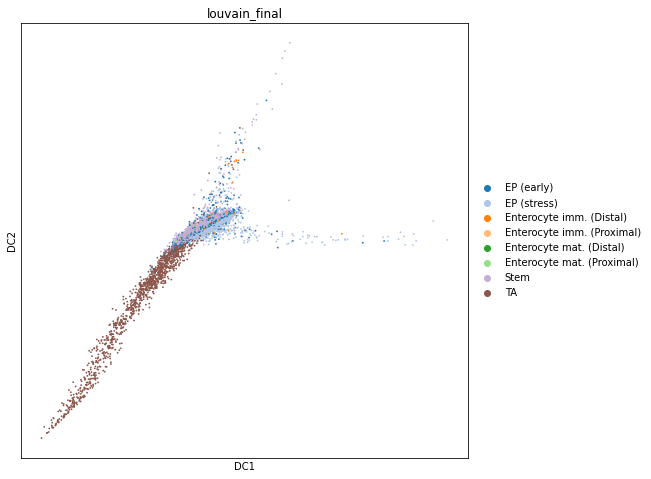

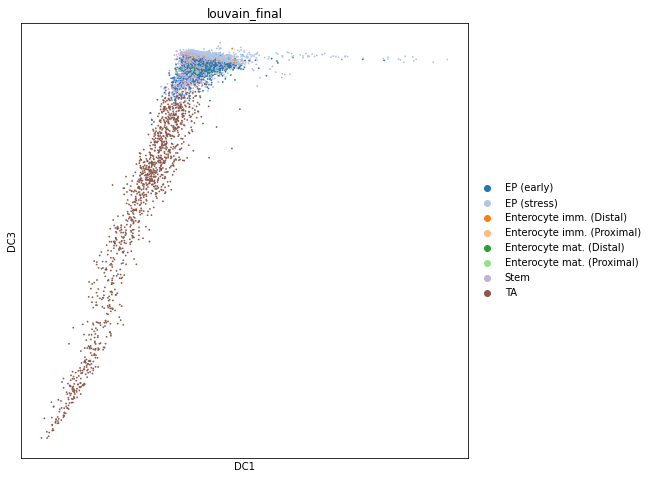

In [168]:
sc.pl.diffmap(adata_ent, components='1,2', color='louvain_final')
sc.pl.diffmap(adata_ent, components='1,3', color='louvain_final')

In [169]:
#Find the stem cell with the highest DC3 value to act as root for the diffusion pseudotime and compute DPT
stem_mask = np.isin(adata_ent.obs['louvain_final'], 'Stem')
max_stem_id = np.argmax(adata_ent.obsm['X_diffmap'][stem_mask,2])
root_id = np.arange(len(stem_mask))[stem_mask][max_stem_id]
adata_ent.uns['iroot'] = root_id

#Compute dpt
sc.tl.dpt(adata_ent)

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


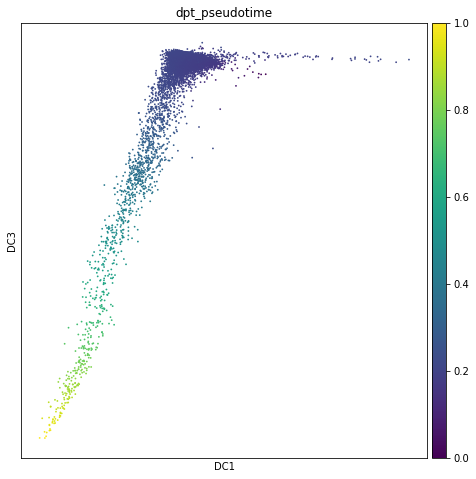

In [170]:
#Visualize pseudotime over differentiation
sc.pl.diffmap(adata_ent, components='1,3', color='dpt_pseudotime')

## 3.6 Gene expression dynamics

#### 进行基因表达动力学(Gene expression dynamics)的原因：由于推断的轨迹可能是转录噪声拟合的结果。同时，在整个伪时间范围内连续平稳变化的基因是决定轨迹的关键基因，可用于识别潜在的生物学过程。

In [234]:
sce_simple_startend.to_df()

Mrpl15 4732440D04Rik Cspp1 Arfgef1 Ncoa2 Tram1 Xkr9 Mcm3 Paqr8  \
AAACATACCTTACT    NaN           NaN   NaN     NaN   NaN   NaN  NaN  NaN   NaN   
AAACATACTTTGCT    NaN           NaN   NaN     NaN   NaN   NaN  NaN  NaN   NaN   
AAACCGTGCAGTCA    NaN           NaN   NaN     NaN   NaN   NaN  NaN  NaN   NaN   
AAACGCTGCAGTCA    NaN           NaN   NaN     NaN   NaN   NaN  NaN  NaN   NaN   
AAACGCTGCGTGAT    NaN           NaN   NaN     NaN   NaN   NaN  NaN  NaN   NaN   
...               ...           ...   ...     ...   ...   ...  ...  ...   ...   
TTTAGAGATCTACT    NaN           NaN   NaN     NaN   NaN   NaN  NaN  NaN   NaN   
TTTATCCTTGCAGT    NaN           NaN   NaN     NaN   NaN   NaN  NaN  NaN   NaN   
TTTCAGTGACCAGT    NaN           NaN   NaN     NaN   NaN   NaN  NaN  NaN   NaN   
TTTCGAACAGAACA    NaN           NaN   NaN     NaN   NaN   NaN  NaN  NaN   NaN   
TTTGCATGGAGGAC    NaN           NaN   NaN     NaN   NaN   NaN  NaN  NaN   NaN   

               Tram2  ... Fam160b1 Atrnl1 Pnliprp1 Pnliprp2 Rab11fip2 Nanos1  \
AAACATACCTTACT   NaN  ...      NaN    NaN      NaN      NaN       NaN    NaN   
AAACATACTTTGCT   NaN  ...      NaN    NaN      NaN      NaN       NaN    NaN   
AAACCGTGCAGTCA   NaN  ...      NaN    NaN      NaN      NaN       NaN    NaN   
AAACGCTGCAGTCA   NaN  ...      NaN    NaN      NaN      NaN       NaN    NaN   
AAACGCTGCGTGAT   NaN  ...      NaN    NaN      NaN      NaN       NaN    NaN   
...              ...  ...      ...    ...      ...      ...       ...    ...   
TTTAGAGATCTACT   NaN  ...      NaN    NaN      NaN      NaN       NaN    NaN   
TTTATCCTTGCAGT   NaN  ...      NaN    NaN      NaN      NaN       NaN    NaN   
TTTCAGTGACCAGT   NaN  ...      NaN    NaN      NaN      NaN       NaN    NaN   
TTTCGAACAGAACA   NaN  ...      NaN    NaN      NaN      NaN       NaN    NaN   
TTTGCATGGAGGAC   NaN  ...      NaN    NaN      NaN      NaN       NaN    NaN   

               Grk5 Zfp950 mt-Co1 CAAA01147332.1  
AAACATACCTTACT  NaN    NaN    NaN            NaN  
AAACATACTTTGCT  NaN    NaN    NaN            NaN  
AAACCGTGCAGTCA  NaN    NaN    NaN            NaN  
AAACGCTGCAGTCA  NaN    NaN    NaN            NaN  
AAACGCTGCGTGAT  NaN    NaN    NaN            NaN  
...             ...    ...    ...            ...  
TTTAGAGATCTACT  NaN    NaN    NaN            NaN  
TTTATCCTTGCAGT  NaN    NaN    NaN            NaN  
TTTCAGTGACCAGT  NaN    NaN    NaN            NaN  
TTTCGAACAGAACA  NaN    NaN    NaN            NaN  
TTTGCATGGAGGAC  NaN    NaN    NaN            NaN  

[9468 rows x 4000 columns]

In [232]:
%%R -i sce_simple_startend -o gam.pval
library(gam)
library(clusterExperiment)

#Set the pseudotime variable
t <- sce_simple_startend$slingPseudotime_1

#Extract the gene expression matrix
Y <- assay(sce_simple_startend)

# fit a GAM with a loess term for pseudotime
#Note: This takes a while
gam.pval <- apply(Y,1,function(z){
  d <- data.frame(z=z, t=t)
  tmp <- gam(z ~ lo(t), data=d)
  p <- summary(tmp)[4][[1]][1,5]
  p
})


Error in assay(sce_simple_startend) : 
  'assay(<SingleCellExperiment>, i="missing", ...) length(assays(<SingleCellExperiment>)) is 0'


In [ ]:
%%R -i sce_simple_startend -i gam.pval -o heatdata  -w 600 -h 1200
library(gam)
library(clusterExperiment)

#Select the top 100 most significant genes that change over pseudotime
topgenes <- names(sort(gam.pval, decreasing = FALSE))[1:100]
heatdata <- assay(sce_simple_startend)[rownames(assay(sce_simple_startend)) %in% topgenes, 
                        order(t, na.last = NA)]

#Scale the data per gene for visualization
heatdata <- t(scale(t(heatdata)))

#Trimm z-score scale
heatdata[heatdata > 3] = 3
heatdata[heatdata < -3] = -3

#Get cluster assignment
heatclus <- sce_simple_startend$louvain_r0.5[order(t, na.last = NA)]

#Set up a clusterExperiment data structure for heatmap visualization
ce <- clusterExperiment(heatdata, heatclus, transformation = function(x){x})

#Plot the heatmap
plotHeatmap(ce, clusterSamplesData = "orderSamplesValue", visualizeData = 'transformed', fontsize=15)

In [229]:
entero_markers = marker_genes['Enterocyte (Proximal)'] + marker_genes['Enterocyte (Distal)']

In [ ]:
%%R -i entero_markers -i heatdata
print(rownames(heatdata)[rownames(heatdata) %in% entero_markers])

## 3.7 Metastable States

#### 亚稳态(Metastable States)是一个相对稳定但又会变化的状态

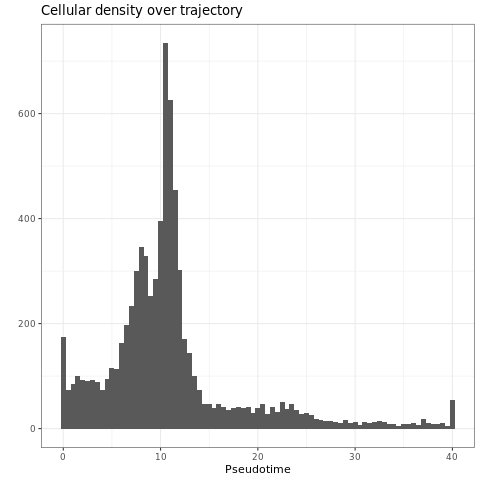

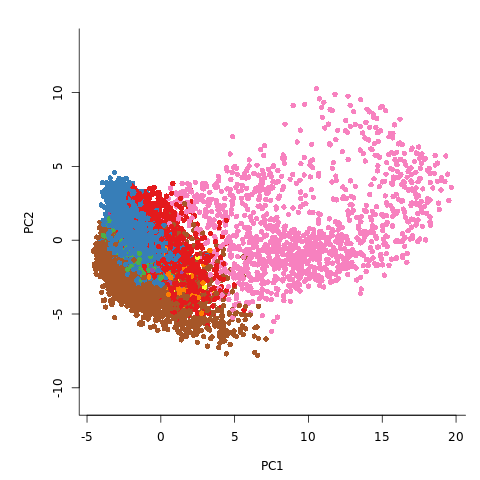

In [184]:
%%R -i sce_startend_nbc
require(ggplot2)
require(plyr)

pt1 <- sce_startend_nbc$slingPseudotime_1
clustDat <- sce_startend_nbc$louvain_final

#Subset data to only include cells on lineage 1
clustDat <- clustDat[!is.na(pt1)]
pt1 <- pt1[!is.na(pt1)]
df = data.frame(clusters = clustDat, pt = pt1)

#Bin clusters in same way as pseudotime:
bin_width = 0.5
max_bin = ceiling(max(df$pt)*2)/2
df['bins'] = cut(df$pt, breaks=seq(-bin_width/2, max_bin, bin_width))

#Find dominant cluster in each bin
Mode <- function(x) {
  ux <- unique(x)
  ux[which.max(tabulate(match(x, ux)))]
}

dominant_clusters = sapply(levels(df$bins), function(x){Mode(df$clust[df$bins==x])})
levels(dominant_clusters) <- c(levels(dominant_clusters), 'None')
dominant_clusters[is.na(dominant_clusters)] <- 'None'

#Define colour map
cmap <- brewer.pal(11,'Set1')

#Plot meta-stable states

#############################################
##########填充fill报错，fill=I(cmap[dominant_clusters])
##############################################

p <- qplot(sce_startend_nbc$slingPseudotime_1, geom='histogram', main='Cellular density over trajectory', xlab='Pseudotime', binwidth=bin_width)+ 
theme_bw() +
scale_colour_manual(name="Cluster", values=c('EP (Distal)'=cmap[levels(dominant_clusters)[1]], 'EP (early)'=cmap[levels(dominant_clusters)[2]], EP_early="purple"))
print(p)

#Plot of lineages with clusters visualized
par(xpd=TRUE)
par(mar=c(4.5,5.5,2,1))
plot(reducedDims(sce_startend_nbc)$PCA[,c(1,2)], col = brewer.pal(11,'Set1')[sce$louvain_final], pch=16, asp = 1, bty='L', xlab='PC1', ylab='PC2')
# lines(SlingshotDataSet(sce_startend_nbc), lwd=2, type='lineages')
# legend(x=10, y=20, legend=unique(colData(sce)$louvain_final), fill=cmap[as.integer(unique(colData(sce)$louvain_final))])

## 3.8 Partition-based graph abstraction

#### PAGA(Partition-based graph abstraction)是一种在细胞水平上进行联合分析

#### 将细胞相似度高于期望值的两个簇之间用线连接，即用点代表单细胞簇，轨迹作为簇之间相连的边，可以同时展示数据的静态和动态属性。

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


--> added 'pos', the PAGA positions (adata.uns['paga'])


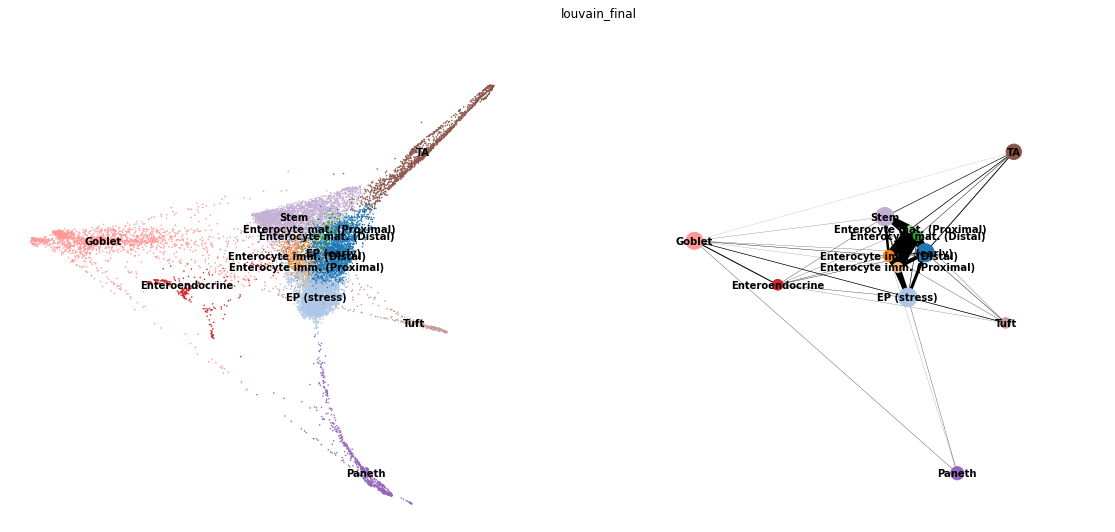

--> added 'pos', the PAGA positions (adata.uns['paga'])


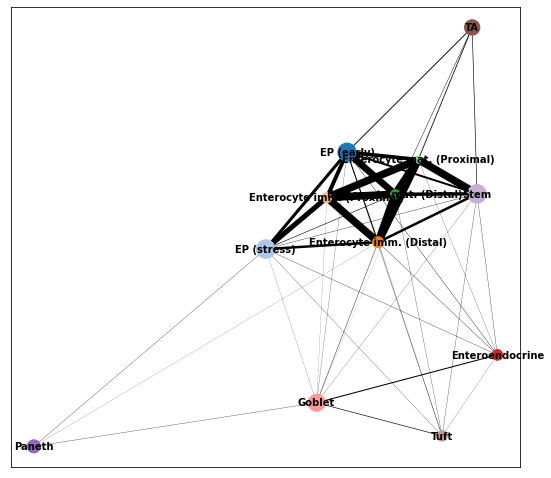

In [185]:
sc.tl.paga(adata, groups='louvain_final')
sc.pl.paga_compare(adata)
sc.pl.paga(adata)

running PAGA


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


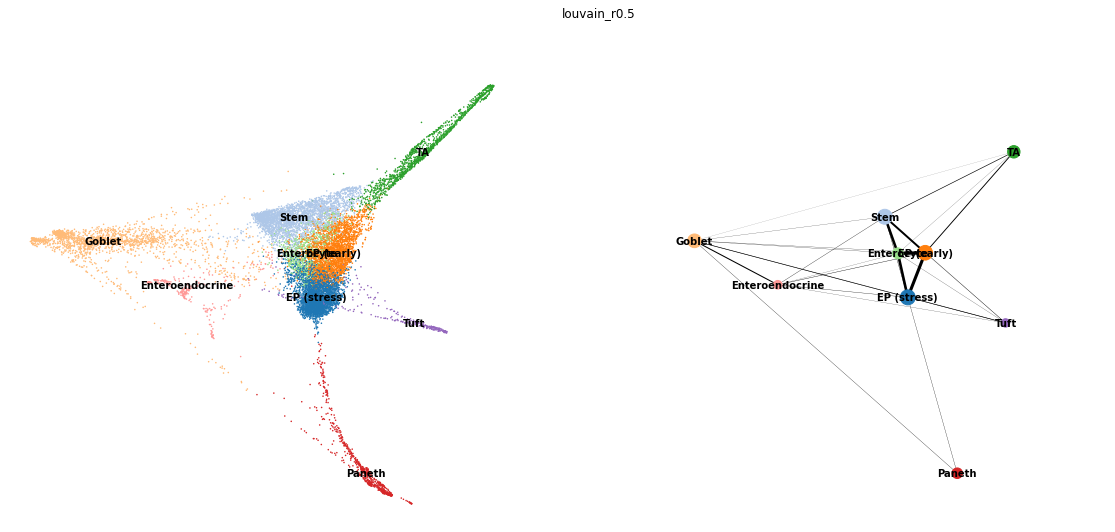

--> added 'pos', the PAGA positions (adata.uns['paga'])


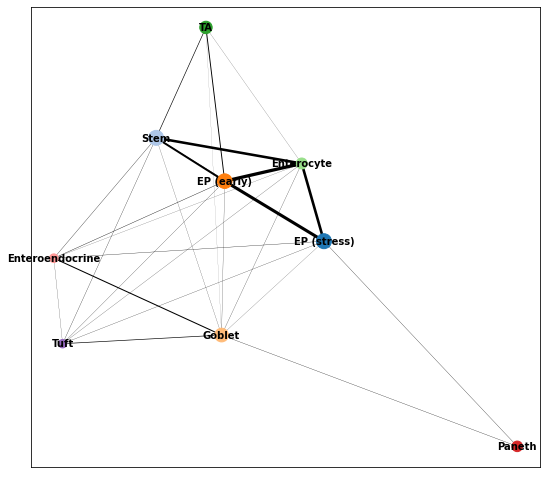

In [186]:
sc.tl.paga(adata, groups='louvain_r0.5')
sc.pl.paga_compare(adata)
sc.pl.paga(adata)

--> added 'pos', the PAGA positions (adata.uns['paga'])


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


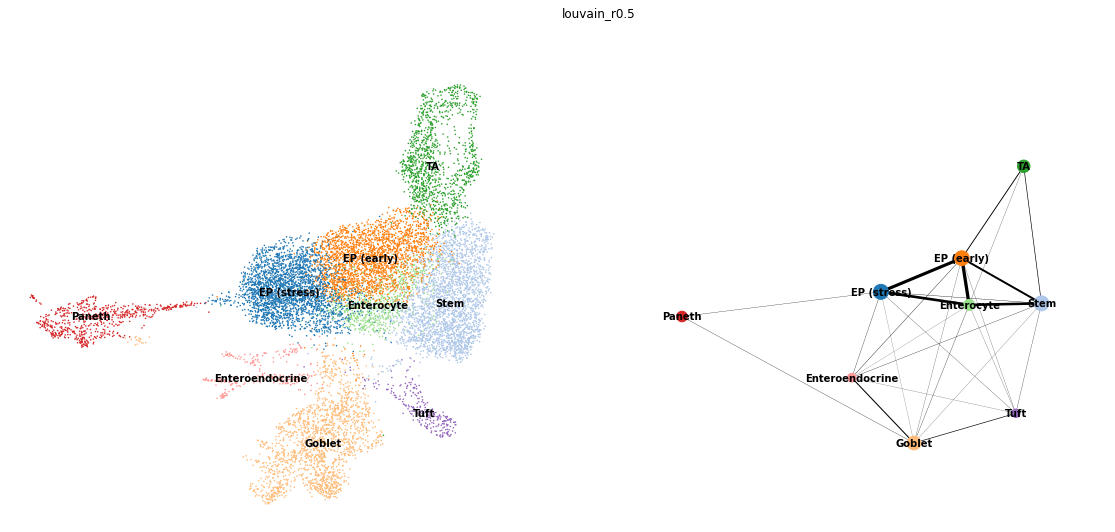

In [187]:
sc.pl.paga_compare(adata, basis='umap')

--> added 'pos', the PAGA positions (adata.uns['paga'])


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


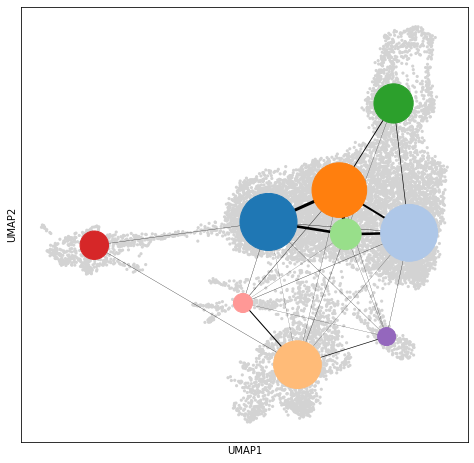

In [189]:
fig1, ax1 = plt.subplots()
sc.pl.umap(adata, size=40, ax=ax1, show=False)
sc.pl.paga(adata, pos=adata.uns['paga']['pos'], show=False, node_size_scale=10, node_size_power=1, ax=ax1, text_kwds={'alpha':0})
#plt.savefig('./figures/umap_paga_overlay_gut.pdf', dpi=300, format='pdf')
plt.show()

In [190]:
#Create new Anndata object with non-batch corrected data
adata_test = adata.copy()
adata_test.X = adata.raw.X

In [191]:
#Regress out counts and redo pre-processing
sc.pp.regress_out(adata_test, 'n_counts')
sc.pp.pca(adata_test, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata_test)

regressing out n_counts


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


    finished (0:03:22)
computing PCA
    on highly variable genes
    with n_comps=50


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


running PAGA


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


--> added 'pos', the PAGA positions (adata.uns['paga'])


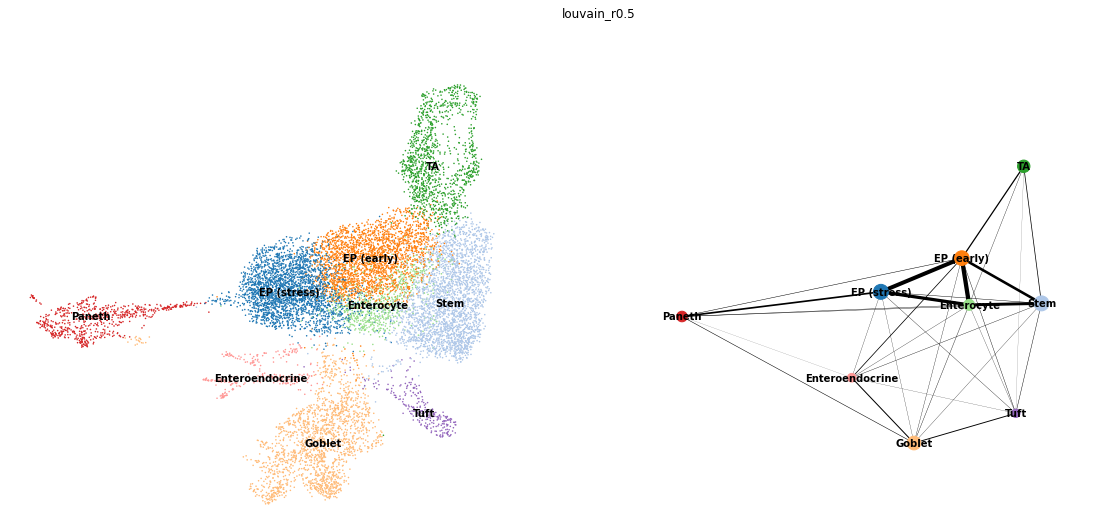

--> added 'pos', the PAGA positions (adata.uns['paga'])


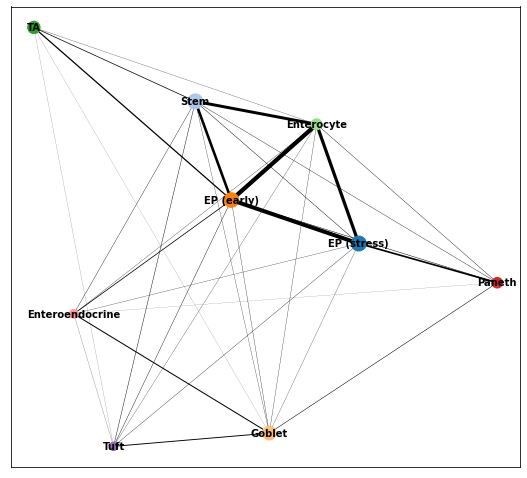

In [192]:
#Recalculate PAGA
sc.tl.paga(adata_test, groups='louvain_r0.5')
sc.pl.paga_compare(adata_test, basis='umap')
sc.pl.paga(adata_test)

## (2)基因水平

## 3.9 Gene-level analysis

### 3.9.1 Differential testing

#### 差异表达分析(Differential expression analysis)：表达数据分析的一个常见问题是两个实验条件之间是否有基因发生了差异表达。

In [193]:
#Preprocess data for use in MAST
data_mat = adata.raw.X.T
obs = adata.obs
var = adata.var

In [194]:
%%R -i data_mat -i obs -i var -o result_ent_de -o result_paneth_de
require(MAST)

#Prepare data sets for SingleCellExperiment data structure conversion
obs['wellKey'] = row.names(obs)
var['primerid'] = row.names(var)


#Convert to SingleCellExperiment type
sca <- FromMatrix(exprsArray=data_mat, cData=obs, fData=var)


#Compute Gene detection rate
cdr <- colSums(assay(sca)>0)
colData(sca)$ngeneson = scale(cdr)


#Create data subsets for paneth and Enterocyte subpopulations
sca_ent <- subset(sca, with(colData(sca), louvain_r0.5=='Enterocyte'))
sca_paneth <- subset(sca, with(colData(sca), louvain_r0.5=='Paneth'))


#Filter out non-expressed genes in the subsets
print("Dimensions before subsetting:")
print(dim(sca_ent))
print(dim(sca_paneth))
print("")

sca_ent_filt = sca_ent[rowSums(assay(sca_ent)) != 0, ]
sca_paneth_filt = sca_paneth[rowSums(assay(sca_paneth)) != 0, ]

print("Dimensions after subsetting:")
print(dim(sca_ent_filt))
print(dim(sca_paneth_filt))


#Define & run hurdle model - Enterocytes
zlmCond_ent <- zlm(formula = ~prox_dist + donor + ngeneson, sca=sca_ent_filt)
summaryCond_ent <- summary(zlmCond_ent, doLRT='prox_distProximal')
summaryDt_ent <- summaryCond_ent$datatable

result_ent <- merge(summaryDt_ent[contrast=='prox_distProximal' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
                 summaryDt_ent[contrast=='prox_distProximal' & component=='logFC', .(primerid, coef)],
                 by='primerid') #logFC coefficients

#Correct for multiple testing (FDR correction) and filtering
result_ent[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
result_ent_de = result_ent[result_ent$FDR<0.01,, drop=F]
result_ent_de = result_ent_de[order(result_ent_de$FDR),]


#Define & run hurdle model - paneth cells
zlmCond_paneth <- zlm(formula = ~prox_dist + donor + ngeneson, sca=sca_paneth_filt)
summaryCond_paneth <- summary(zlmCond_paneth, doLRT='prox_distProximal')
summaryDt_paneth <- summaryCond_paneth$datatable

result_paneth <- merge(summaryDt_paneth[contrast=='prox_distProximal' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
                 summaryDt_paneth[contrast=='prox_distProximal' & component=='logFC', .(primerid, coef)],
                 by='primerid') #logFC coefficients

#Correct for multiple testing (FDR correction) and filtering
result_paneth[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
result_paneth_de = result_paneth[result_paneth$FDR<0.01,, drop=F]
result_paneth_de = result_paneth_de[order(result_paneth_de$FDR),]

[1] "Dimensions before subsetting:"
[1] 12818   747
[1] 12818   641
[1] ""
[1] "Dimensions after subsetting:"
[1] 12275   747
[1] 12335   641


In [210]:
#此数据框为R语言的数据框
result_paneth_de

primerid    Pr(>Chisq)      coef           FDR
1        Fabp6  1.168049e-96 -1.092165  1.440788e-92
2       Guca2a  1.861919e-66 -2.007025  1.148339e-62
3      Gm21002  3.724133e-62 -1.771447  1.531239e-58
4       Defa20  1.219301e-61 -1.567412  3.760019e-58
5       Defa22  1.932171e-56 -2.830456  4.766667e-53
..         ...           ...       ...           ...
308      H2-K1  2.296072e-04 -0.221109  9.171663e-03
309    Zc3hav1  2.297563e-04 -0.122476  9.171663e-03
310     Zfp740  2.359650e-04  0.138605  9.389122e-03
311  Serpina1b  2.469572e-04 -0.072452  9.794911e-03
312      Cdca7  2.480618e-04  0.240779  9.807188e-03

[312 rows x 4 columns]

In [211]:
#Convert rpy2 objects to pandas dataframes
#本案例使用的rpy2的版本为3.3.5

import rpy2.robjects as ro
from rpy2.robjects.conversion import localconverter

with localconverter(ro.default_converter + pandas2ri.converter):
    paneth_de = ro.conversion.rpy2py(result_paneth_de)
    
with localconverter(ro.default_converter + pandas2ri.converter):
    ent_de = ro.conversion.rpy2py(result_ent_de)

In [213]:
#Show top 20 differentially expressed genes for enterocytes (up- and down-regulated)
print(ent_de.shape)
ent_de.iloc[:,:20]

(304, 4)


primerid    Pr(>Chisq)      coef           FDR
1      Prap1  5.449775e-57  1.089220  6.689598e-53
2       Cd74  1.181348e-48 -1.278806  7.250522e-45
3     H2-Ab1  9.478164e-48 -0.875336  3.878149e-44
4     Rpl35a  4.545267e-45  0.595144  1.394829e-41
5     Tspan1  9.973795e-44 -0.697378  2.448567e-40
..       ...           ...       ...           ...
300  Gm11808  2.113784e-04  0.127707  8.648899e-03
301    Snrpn  2.151887e-04  0.086540  8.775553e-03
302    Sqrdl  2.257293e-04 -0.114317  9.174925e-03
303   Psmb10  2.288002e-04 -0.217126  9.269049e-03
304   Tm4sf5  2.346445e-04  0.175596  9.474545e-03

[304 rows x 4 columns]

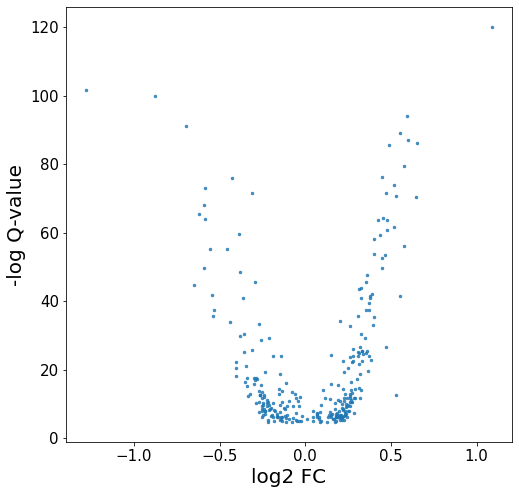

In [214]:
#Volcano plot of results
ent_de['-logQ'] = -np.log(ent_de['FDR'])
lowqval_de = ent_de.loc[ent_de['-logQ'] > 200]
other_de = ent_de.loc[ent_de['-logQ'] < 200]

fig, ax = plt.subplots()
sb.regplot(other_de['coef'], other_de['-logQ'], fit_reg=False, scatter_kws={'s':6})
sb.regplot(lowqval_de['coef'], lowqval_de['-logQ'], fit_reg=False, scatter_kws={'s':6})
ax.set_xlabel("log2 FC", fontsize=20)
ax.set_ylabel("-log Q-value", fontsize=20)
ax.tick_params(labelsize=15)

# Label names and positions
x = [i-0.2 for i in lowqval_de['coef']]
y = [i+10 for i in lowqval_de['-logQ']]
labels = lowqval_de['primerid']

# Show only some labels to avoid overcrowding the figure
to_remove = np.where([i < 230 for i in y])[0]
labels = ["" if i in to_remove else lab for i,lab in enumerate(labels) ]

#Move up two labels
y = [y[i]+10 if txt == 'Krt8' else y[i] for i,txt in enumerate(labels)]
y = [y[i]+20 if txt == 'Cd9' else y[i] for i,txt in enumerate(labels)]

#Move down one label
y = [y[i]-20 if txt == 'Phgr1' else y[i] for i,txt in enumerate(labels)]

for i,txt in enumerate(labels):
    ax.annotate(txt, (x[i], y[i]))
plt.show()

In [215]:
#See overlaps with markers expected for proximal and distal enterocytes
prox_de_set = set(ent_de['primerid'][ent_de['coef'] > 0])
dist_de_set = set(ent_de['primerid'][ent_de['coef'] < 0])
print("Fraction of proximal enterocyte markers in up-regulated proximal DE genes: {}".format(len(prox_de_set.intersection(marker_genes['Enterocyte (Proximal)']))/len(marker_genes['Enterocyte (Proximal)'])))
print("Fraction of distal enterocyte markers in up-regulated proximal DE genes: {}".format(len(prox_de_set.intersection(marker_genes['Enterocyte (Distal)']))/len(marker_genes['Enterocyte (Distal)'])))

print()
print("Fraction of proximal enterocyte markers in up-regulated distal DE genes: {}".format(len(dist_de_set.intersection(marker_genes['Enterocyte (Proximal)']))/len(marker_genes['Enterocyte (Proximal)'])))
print("Fraction of distal enterocyte markers in up-regulated distal DE genes: {}".format(len(dist_de_set.intersection(marker_genes['Enterocyte (Distal)']))/len(marker_genes['Enterocyte (Distal)'])))

Fraction of proximal enterocyte markers in up-regulated proximal DE genes: 0.125
Fraction of distal enterocyte markers in up-regulated proximal DE genes: 0.022727272727272728

Fraction of proximal enterocyte markers in up-regulated distal DE genes: 0.020833333333333332
Fraction of distal enterocyte markers in up-regulated distal DE genes: 0.20454545454545456


### 3.9.2 Gene set analysis

#### 我们可以通过基因共有的特征对基因进行分组并检验这些特征在候补基因列表中的出现是否显著富集 (overrepresented)以便更好的解释结果。

In [216]:
#Interpretation of differentially expressed genes in paneth cells - g:profiler
paneth_enrichment = gprofiler(paneth_de['primerid'], custom_bg=adata.var_names.tolist(), organism='mmusculus', correction_method='fdr', src_filter=['GO:BP'])

In [217]:
paneth_enrich_results = paneth_enrichment.sort_values('p.value').iloc[:,[2,3,5,6,11]]

In [218]:
pd.set_option("display.max_colwidth", 800)
paneth_enrich_results.iloc[:50,:]

p.value  term.size  overlap.size  recall  \
term.id                                                     
GO:0002181  4.220000e-15         78            22   0.077   
GO:0006518  9.300000e-14        642            55   0.192   
GO:0006412  9.460000e-14        518            49   0.171   
GO:0043604  1.700000e-13        610            53   0.185   
GO:1901566  2.590000e-13       1246            79   0.276   
GO:0043043  2.590000e-13        533            49   0.171   
GO:0043603  3.220000e-13        802            61   0.213   
GO:0042742  7.360000e-09        113            19   0.066   
GO:0042274  4.510000e-07         61            13   0.045   
GO:0000028  8.440000e-07         18             8   0.028   
GO:0009617  1.390000e-05        340            27   0.094   
GO:0042254  1.890000e-05        240            22   0.077   
GO:0019730  5.230000e-05         29             8   0.028   
GO:0098542  6.560000e-05        259            22   0.077   
GO:0009605  1.390000e-04       1240            58   0.203   
GO:0051707  1.580000e-04        513            32   0.112   
GO:0043207  1.580000e-04        513            32   0.112   
GO:0022613  1.780000e-04        369            26   0.091   
GO:0002478  2.390000e-04         10             5   0.017   
GO:0006959  3.290000e-04         63            10   0.035   
GO:0006364  3.740000e-04        166            16   0.056   
GO:0050829  4.130000e-04         28             7   0.024   
GO:0000462  4.130000e-04         28             7   0.024   
GO:0009607  4.190000e-04        542            32   0.112   
GO:0001906  5.000000e-04         67            10   0.035   
GO:0030490  5.520000e-04         41             8   0.028   
GO:0048002  7.440000e-04         31             7   0.024   
GO:0006952  7.470000e-04        754            39   0.136   
GO:0061844  1.010000e-03         22             6   0.021   
GO:0016072  1.670000e-03        191            16   0.056   
GO:0019884  1.760000e-03         15             5   0.017   
GO:1901135  2.670000e-03        744            37   0.129   
GO:1902600  2.720000e-03         83            10   0.035   
GO:0019882  4.190000e-03         55             8   0.028   
GO:0042255  5.190000e-03         57             8   0.028   
GO:0051704  5.190000e-03       1200            51   0.178   
GO:0006950  5.190000e-03       2243            82   0.287   
GO:0002504  6.360000e-03         11             4   0.014   
GO:0002821  7.030000e-03         61             8   0.028   
GO:0035821  7.160000e-03         78             9   0.031   
GO:0006810  7.230000e-03       2666            93   0.325   
GO:0019886  7.990000e-03          5             3   0.010   
GO:0002699  1.060000e-02        121            11   0.038   
GO:1901564  1.060000e-02       4354           137   0.479   
GO:0043902  1.060000e-02        121            11   0.038   
GO:0001916  1.110000e-02         13             4   0.014   
GO:0009141  1.180000e-02        211            15   0.052   
GO:0022900  1.290000e-02        105            10   0.035   
GO:0001913  1.460000e-02         25             5   0.017   
GO:0002711  1.460000e-02         25             5   0.017   

                                                                                                 term.name  
term.id                                                                                                     
GO:0002181                                                                         cytoplasmic translation  
GO:0006518                                                                       peptide metabolic process  
GO:0006412                                                                                     translation  
GO:0043604                                                                      amide biosynthetic process  
GO:1901566                                                    organonitrogen compound biosynthetic process  
GO:0043043                                                                    pep

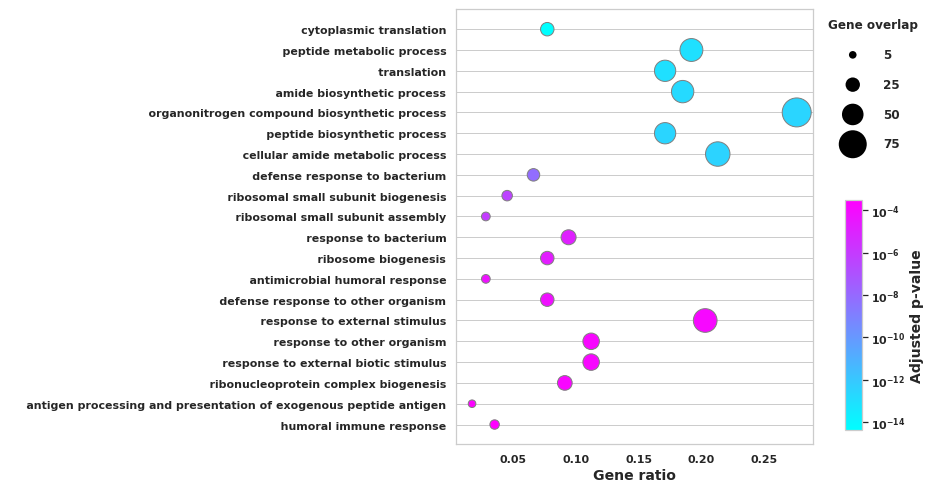

In [219]:
#Plotting the Enrichment results
data_to_plot = paneth_enrich_results.iloc[:20,:].copy()
data_to_plot['go.id'] = data_to_plot.index

norm = colors.LogNorm(data_to_plot['p.value'].min(), data_to_plot['p.value'].max())
sm = plt.cm.ScalarMappable(cmap="cool", norm=norm)
sm.set_array([])

rcParams.update({'font.size': 14, 'font.weight': 'bold'})

sb.set(style="whitegrid")

path = plt.scatter(x='recall', y="term.name", c='p.value', cmap='cool', norm=colors.LogNorm(data_to_plot['p.value'].min(), data_to_plot['p.value'].max()), data=data_to_plot, linewidth=1, edgecolor="grey", s=[(i+10)**1.5 for i in data_to_plot['overlap.size']])
ax = plt.gca()
ax.invert_yaxis()

ax.set_ylabel('')
ax.set_xlabel('Gene ratio', fontsize=14, fontweight='bold')
ax.xaxis.grid(False)
ax.yaxis.grid(True)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

#Colorbar
fig = plt.gcf()
cbaxes = fig.add_axes([0.8, 0.15, 0.03, 0.4]) 
cbar = ax.figure.colorbar(sm, ticks=[float(1e-14), float(1e-12), float(1e-10), float(1e-8), float(1e-6), float(1e-4)], shrink=0.5, anchor=(0,0.1), cax=cbaxes)
cbar.ax.set_yticklabels(['$10^{-14}$', '$10^{-12}$', '$10^{-10}$', '$10^{-8}$', '$10^{-6}$', '$10^{-4}$'])
cbar.set_label("Adjusted p-value", fontsize=14, fontweight='bold')

#Size legend
l1 = plt.scatter([],[], s=(5+10)**1.5, edgecolors='none', color='black')
l2 = plt.scatter([],[], s=(25+10)**1.5, edgecolors='none', color='black')
l3 = plt.scatter([],[], s=(50+10)**1.5, edgecolors='none', color='black')
l4 = plt.scatter([],[], s=(75+10)**1.5, edgecolors='none', color='black')

labels = ["5", "25", "50", "75"]

leg = plt.legend([l1, l2, l3, l4], labels, ncol=1, frameon=False, fontsize=12,
handlelength=1, loc = 'center left', borderpad = 1, labelspacing = 1.4,
handletextpad=2, title='Gene overlap', scatterpoints = 1,  bbox_to_anchor=(-2, 1.5), facecolor='black')

#plt.savefig('./figures/Haber_paneth_cell_GO_BP_enrichment.pdf', dpi=300, format='pdf')

plt.show()

# 4 Summary

#### 在这个案例研究中，我们经历了 scRNA-seq 数据分析工作流的典型步骤。单细胞测序的一般步骤主要包括预处理和可视化以及下游分析两步：

#### (1)预处理和可视化主要包括：细胞和基因质量控制、标准化、批次校正、选择高变异基因(特征选择)、可视化和细胞周期评分。在这些步骤中，对数据的整体结构进行探索和过滤，以产生最佳的下游分析结果。

#### (2)下游分析主要分为细胞水平和基因水平的方法。

#### 注意：任何单独的数据分析脚本都不会始终遵循所有这些步骤。